<h1 style="text-align: center;font-size: 58px;">NURSERY</h1>
Il <em>Nursery Database</em> è stato derivato da un modello decisionale gerarchico originariamente sviluppato per classificare le domande di ammissione agli asili. È stato utilizzato per diversi anni negli anni ’80, quando a Lubiana, in Slovenia, vi era un’eccessiva richiesta di iscrizione a questi asili, e spesso le domande rifiutate richiedevano una spiegazione oggettiva.
<p>La decisione finale dipendeva da tre sottoproblemi:</p>
<ul>
  <li>Occupazione dei genitori e presenza dell’asilo per il bambino,</li>
  <li>Struttura familiare e situazione finanziaria,</li>
  <li>Quadro sociale e sanitario della famiglia.</li>
</ul>

<p>Il modello gerarchico classifica le domande di ammissione agli asili secondo la seguente struttura concettuale:</p>


<ul>
  <li><strong style="display:inline-block; margin-top:10px; margin-bottom:10px;">EMPLOY</strong> – Occupazione dei genitori e dell'asilo nido del bambino
    <ul>
        <li>parents – Professione dei genitori</li>
        <ul>
            <li>Valori unici: usual, pretentious, great_pret</li>
        </ul>
      <li>has_nurs – Asilo nido</li>
        <ul>
            <li>Valori unici: proper, less_proper, improper, critical, very_crit</li>
        </ul>
    </ul>
  </li>

  <li><strong style="display:inline-block; margin-top:10px; margin-bottom:10px;">STRUCT_FINAN</strong> – Struttura familiare e situazione finanziaria
    <ul>
      <li>form – Forma della famiglia</li>
        <ul>
            <li>Valori unici: complete, completed, incomplete, foster</li>
        </ul>
      <li>children – Numero di figli</li>
        <ul>
            <li>Valori unici: 1, 2, 3, more</li>
        </ul>
      <li>housing – Condizioni abitative</li>
        <ul>
            <li>Valori unici: convenient, less_conv, critical</li>
        </ul>
      <li>finance – Situazione finanziaria della famiglia</li>
        <ul>
            <li>Valori unici: convenient, inconv</li>
        </ul>
    </ul>
  </li>

  <li><strong style="display:inline-block; margin-top:10px; margin-bottom:10px;">SOC_HEALTH</strong> – Quadro sociale e sanitario della famiglia
    <ul>
      <li>social – Condizioni sociali</li>
        <ul>
            <li>Valori unici: nonprob, slightly_prob, problematic</li>
        </ul>
      <li>health – Condizioni sanitarie</li>
        <ul>
            <li>Valori unici: recommended, priority, not_recom</li>
        </ul>
    </ul>
  </li>
</ul>

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

<h1>Funzione per l'utilizzo dei classificatori</h1>
<p>Abbiamo implementato una funzione che prende in input il modello di classificazione, le divisioni in <strong>train</strong> e <strong>test</strong> del dataset, diviso in <strong>X</strong> e <strong>y</strong>, e il nome del modello. La funzione svolge diversi compiti:</p>
<ul>
     <div style="margin-top: 1em;"><li><h3>Addestramento:</h3></li></div>
        <ul>
            <li>Addestra il modello utilizzando le <strong>X_train</strong> e <strong>y_train</strong></li>
        </ul>
     <div style="margin-top: 1em;"><li><h3>Predizione:</h3></li></div>
        <ul>
            <li>Predice le classi per i due gruppi <strong>y_train</strong> e <strong>y_test</strong>, e in più viene calcolata <strong>y_pred_proba</strong>, che indica la probabilità di appartenere a ciascuna classe</li>
        </ul>
    <div style="margin-top: 1em;"><li><h3>Metriche su train e test:</h3></li></div>
        <ul>
            <li>Accuracy - percentuale di predizioni corrette: $$\frac{TP + TN}{TP + TN + FP + FN}$$</li>
            <li>Precision - quante delle previsioni positive sono corrette: $$\frac{TP}{TP + FP}$$</li>
            <li>Recall - quante delle vere istanze sono state correttamente trovate: $$\frac{TP}{TP + FN}$$</li>
            <li>F1-Score - meida armonica fra Precision e Recall: $$ 2 \cdot \frac{Precision  \cdot Recall}{Precision + Recall}$$</li>
        </ul>
Per le ultime tre metriche abbiamo applicato la meida pesata, <em>weighted</em>, perchè migliora la stabilità quando ci sono classi sbilanciate, essendo che la classe 2 ha solo un elemento difficilmente prevedibile.
    <div style="margin-top: 1em;"><li><h3>Matrice di confusione:</h3></li></div>
        <ul>
            <li>Costruisce una matrice che confronta la classe reale e la classe predetta per ciascun valore</li>
        </ul>
    <div style="margin-top: 1em;"><li><h3>Output:</h3></li></div>
        <ul>
            <li>Dataframe che contiene i valori ricavati dalle metriche per train e test</li>
            <li>Matrice di confusione in scala di blu</li>
            <li>Dataframe che mostra la classe corretta, classe predetta e probabilità di appartenere ad ogni classe per ogni elemento. Inoltre, viene visualizzata nello specifico la riga che contiene l'unico elemento della classe 2</li>
        <ul>
</ul>

In [2]:
def evaluate_and_plot(model, X_train, y_train, X_test, y_test, name = "Modello"):
    # Addestramento
    model.fit(X_train, y_train)
    
    # Predizione
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    # Metriche
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)

    prec_train = precision_score(y_train, y_pred_train, average='weighted', zero_division=0)
    prec_test = precision_score(y_test, y_pred_test, average='weighted', zero_division=0)

    rec_train = recall_score(y_train, y_pred_train, average='weighted', zero_division=0)
    rec_test = recall_score(y_test, y_pred_test, average='weighted', zero_division=0)

    f1_train = f1_score(y_train, y_pred_train, average='weighted', zero_division=0)
    f1_test = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
    
    # Matrice di confuzione
    cm = confusion_matrix(y_test, y_pred_test)
    
    # Stampa risultati
    scores_dict = {
                   'Training Set': [acc_train, prec_train, rec_train, f1_train],
                   'Test Set': [acc_test, prec_test, rec_test, f1_test]}
    scores = pd.DataFrame(scores_dict, index=['Accuracy', 'Precision', 'Recall', 'F1-score'])
    display(scores)
    
    # Visualizza matrice di confusione
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap = 'Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.grid(False)
    plt.show()

    y_pred_df = pd.DataFrame({
                          'Pred. Class': y_pred_test, 
                          'P(Class 0) - %': np.round(y_pred_proba[:, 0] * 100, decimals=2), 
                          'P(Class 1) - %': np.round(y_pred_proba[:, 1] * 100, decimals=2), 
                          'P(Class 2) - %': np.round(y_pred_proba[:, 2] * 100, decimals=2),
                          'P(Class 3) - %': np.round(y_pred_proba[:, 3] * 100, decimals=2),
                          'P(Class 4) - %': np.round(y_pred_proba[:, 4] * 100, decimals=2)})
    display(y_pred_df)

    return acc_train,acc_test

# Importazione dei dati e creazione del dataframe

In [3]:
nursery = fetch_ucirepo(id=76) 

X = nursery.data.features 
y = nursery.data.targets

In [4]:
nursery_dataframe = pd.concat([X, y], axis=1)

display(nursery_dataframe)

,parents,has_nurs,form,children,housing,finance,social,health,class
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
...,...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior


<h1>One-hot encoding</h1>
I dati sono stati ora memorizzati nelle variabili X e y. Trasformiamo adesso le etichette delle classi contenute nella variabile target in interi attraverso il <strong>Label encoding</strong>, una tecnica utilizzata per convertire colonne categoriche in valori numerici. 

A seguire, eseguiamo il One-hot encoding, un metodo per convertire le variabili categoriche in formato binario che crea nuove colonne per ciascuna categoria, dove True (che corrisponde all’1 binario) indica che la categoria è presente e False (che corrisponde allo 0 binario)  indica che non lo è. La dimensione del dataframe aumenta così a 28 colonne, ma in questo modo facciamo sì che la PCA possa lavorare sui dati, essendo ora numerici. 

In [5]:
# Copia del dataframe originale
nursery_dataframe_old = nursery_dataframe.copy()
onehot_cols = nursery_dataframe.columns.to_list()[:-1]

#Label encoding
labelenc_class = LabelEncoder()
labelenc_class.fit(nursery_dataframe['class'].values)
nursery_dataframe['class'] = labelenc_class.transform(nursery_dataframe['class'].values)

# One-hot encoding
nursery_dataframe = pd.get_dummies(nursery_dataframe, columns=onehot_cols)

# Crea un DataFrame con le corrispondenze
mapping_df = pd.DataFrame({
    'Etichetta originale': labelenc_class.classes_,
    'Valore numerico': labelenc_class.transform(labelenc_class.classes_)
})

# Mostra il risultato
display(mapping_df.style.hide(axis="index"))
    
display(nursery_dataframe)

Etichetta originale,Valore numerico
not_recom,0
priority,1
recommend,2
spec_prior,3
very_recom,4


,class,parents_great_pret,parents_pretentious,parents_usual,has_nurs_critical,has_nurs_improper,has_nurs_less_proper,has_nurs_proper,has_nurs_very_crit,form_complete,...,housing_critical,housing_less_conv,finance_convenient,finance_inconv,social_nonprob,social_problematic,social_slightly_prob,health_not_recom,health_priority,health_recommended
0,2,False,False,True,False,False,False,True,False,True,...,False,False,True,False,True,False,False,False,False,True
1,1,False,False,True,False,False,False,True,False,True,...,False,False,True,False,True,False,False,False,True,False
2,0,False,False,True,False,False,False,True,False,True,...,False,False,True,False,True,False,False,True,False,False
3,2,False,False,True,False,False,False,True,False,True,...,False,False,True,False,False,False,True,False,False,True
4,1,False,False,True,False,False,False,True,False,True,...,False,False,True,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12955,3,True,False,False,False,False,False,False,True,False,...,True,False,False,True,False,False,True,False,True,False
12956,0,True,False,False,False,False,False,False,True,False,...,True,False,False,True,False,False,True,True,False,False
12957,3,True,False,False,False,False,False,False,True,False,...,True,False,False,True,False,True,False,False,False,True
12958,3,True,False,False,False,False,False,False,True,False,...,True,False,False,True,False,True,False,False,True,False


In [6]:
X = nursery_dataframe.iloc[:,1:].values
y = nursery_dataframe['class'].values

<h1>Suddivisione del dataset</h1>
Settiamo il seed in modo da rendere replicabile la stessa operazione ogni volta che viene ricaricato il codice.
<p>A queto punto utilizziamo la funzione <em>train_test_split()</em> di  sklearn per suddividere il set in <strong>X_train</strong> e <strong>X_test</strong> e le loro rispettive <strong>y</strong>. La percentuale di dati che devono appartenere al set di test è indicata dalla variabile <em>test_p</em>, mentre <em>stratify</em> garantisce che la distribuzione delle classi rimanga proporzionale in train e test.</p>

In [7]:
random_state = 42

test_p = 0.5

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_p, random_state=random_state, shuffle=True, stratify = y)

display(pd.DataFrame({'X_train': X_train.shape, 'X_test': X_test.shape}, index=['N. sanmples', 'N.features']))

# Calcolo della distribuzione delle classi nel test set
class_distribution = pd.Series(y_test).value_counts().sort_index()

# Creazione del DataFrame
distribution_df = pd.DataFrame({
    'Classe': class_distribution.index,
    'Conteggio': class_distribution.values
})

# Decodifica delle classi (se vuoi i nomi originali)
distribution_df['Classe'] = labelenc_class.inverse_transform(distribution_df['Classe'])

# Visualizzazione senza indici
display(distribution_df.style.hide(axis='index'))

,X_train,X_test
N. sanmples,6480,6480
N.features,27,27


Classe,Conteggio
not_recom,2160
priority,2133
recommend,1
spec_prior,2022
very_recom,164


<h1>PCA - Principal Components Analysis</h1>

<p>In questo elaborato vorremmo applicare alcuni modelli di classificazione sia sui dati originali (dopo aver fatto il One Hot Encoding), sia sui dati PCA ridotti, in modo da poter individuare quale modello lavora meglio e su che tipo di dati.

Nel nostro caso, lavorare con 28 variabili potrebbe risultare complicato e rendere complessa la rappresentazione grafica, di conseguenza, applichiamo la PCA; una tecnica che ha lo scopo di ridurre la dimensione del problema preso in analisi, riducendo il numero di variabili, ma senza perdere informazioni. Proprio per questo motivo, la Principal Component Analysis è importantissima per la classificazione dei dati: permette di avere quasi la stessa precisione che si avrebbe studiando il problema con i suoi dati originari</p>

Sia dato un insieme di $N\in\mathbb{N}$ vettori in $\mathbb{R}^n$
$$\mathcal{X} = \{\boldsymbol{x}^{(1)},\ldots ,\boldsymbol{x}^{(N)}\}\subset\mathbb{R}^n$$
e sia $X\in\mathbb{R}^{N\times n}$ la sua rappresentazione matriciale, cioè
$$X = 
\begin{bmatrix}
\boldsymbol{x}^{(1) T}\\
\vdots\\
\boldsymbol{x}^{(N) T}
\end{bmatrix}
$$

Siano $\boldsymbol{\mu},\boldsymbol{\sigma}\in\mathbb{R}^n$ i vettori costituiti rispettivamente dalle medie e dalle deviazioni standard _campionarie_ delle colonne di $X$, cioè
$$\boldsymbol{\mu} = \frac{1}{N}\sum_{i=1}^N\boldsymbol{x}^{(i)} \quad \text{e} \quad 
\boldsymbol{\sigma}^2 =\frac{1}{N-1}\sum_{i=1}^N((x_{1}^{(i)} - \mu_1)^2,\ldots , (x_{n}^{(i)} - \mu_n)^2)=\frac{1}{N-1}\sum_{i=1}^N(\boldsymbol{x}^{(i)} - \boldsymbol{\mu})\odot (\boldsymbol{x}^{(i)} - \boldsymbol{\mu})\,,%^2\,.
$$
Possiamo allora definire due trasformazioni per i dati originari:
<h4>Centramento</h4>
sottraiamo il vettore $\boldsymbol{\mu}$ a tutti i nostri dati, ottenendo il dataset 
$$\bar{X} = 
\begin{bmatrix}
\boldsymbol{x}^{(1)T} - \boldsymbol{\mu}^T\\
\vdots\\
\boldsymbol{x}^{(N)T} - \boldsymbol{\mu}^T
\end{bmatrix}
\,;
$$
<h4>Standardizzazione</h4>
sottraiamo il vettore $\boldsymbol{\mu}$ a tutti i nostri dati e dividiamo elemento per elemento per il vettore $\boldsymbol{\sigma}$; otteniamo quindi il dataset 
$$\widetilde{X} = 
\begin{bmatrix}
(\boldsymbol{x}^{(1)T} - \boldsymbol{\mu}^T)\div\boldsymbol{\sigma}^T\\
\vdots\\
(\boldsymbol{x}^{(N)T} - \boldsymbol{\mu}^T)\div\boldsymbol{\sigma}^T
\end{bmatrix}
\,,$$


Le matrici $\bar{X}$ e $\widetilde{X}$ sono particolarmente utili per calcolare velocemente le matrici di Covarianza e di Correlazione di $X$, cioè:
$${\rm Cov}(X) = \frac{1}{N-1}\bar{X}^T\bar{X}\in\mathbb{R}^{n\times n} \quad \text{e} \quad 
{\rm Corr}(X) = \frac{1}{N-1}\widetilde{X}^T\widetilde{X}\in\mathbb{R}^{n\times n}\,.$$

Poiché la matrice di ${\rm Cov}(X)\in\mathbb{R}^{n\times n}$ è simmetrica e semidefinita positiva, essa è diagonalizzabile, ha autovalori reali e non negativi e si può determinare una base ortonormale di $\mathbb{R}^n$ con gli autovettori ad essi corrispondenti. 

Sia quindi
$$\mathcal{V}=\{\boldsymbol{v}_1,\ldots ,\boldsymbol{v}_n\}\subset\mathbb{R}^n$$
un insieme degli autovettori di ${\rm Cov}(X)$ costituenti una base ortonormale di $\mathbb{R}^n$, dove gli autovettori sono indicizzati in modo che i rispettivi autovalori siano ordinati in ordine decrescente, cioè 
$$\lambda_1\geq \cdots \geq \lambda_n\geq 0\,.$$
Quindi l'autovettore $i$-esimo indica l'$i$-esima direzione di massima varianza dei dati di $X$. Data questa proprietà, i vettori della base $\mathcal{V}$ sono definiti Componenti Principali (PC) di $X$.

Come diretta conseguenza di quanto appena osservato, possiamo quindi sfruttare la base $\mathcal{V}$ per ridurre la dimensione di un problema minimizzando la perdita di informazione.

<h4>PCA e Riduzione di Dimensionalità</h4>

Sia $\mathcal{V}=\{\boldsymbol{v}_1,\ldots ,\boldsymbol{v}_n\}\subset\mathbb{R}^n$ la base delle PC calcolata rispetto ${\rm Cov}(X)$ , sia $ 0<m<n $ il numero di dimensioni alle quali voglio ridurre il mio problema ed indichiamo con $V|_m\in\mathbb{R}^{n\times m}$ la sottomatrice di $V$ data dalle _prime $m$ colonne_. 

Per ottenere una rappresentazione di $\bar{X}$ in $m$ dimensioni sfruttando le PC, basta cambiare i dati in base $\mathcal{V}$ e proiettarli sulle prime $m$ dimensioni, cioè:
$$Y_m = \bar{X}V|_m\,.$$

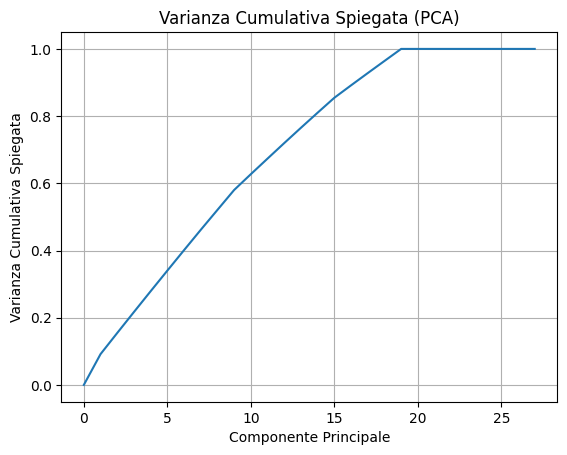

Numero di componenti principali selezionate: 8


In [8]:
# Inizializzazione oggetto PCA
pca = PCA(0.5)

# "Fit" dell'oggetto PCA
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# PCA per il grafico
pca_graph = PCA()
pca_graph.fit(X_train)
pca_3 = PCA(3)
pca_3.fit(X_train)

varianza_spiegata = pca_3.explained_variance_ratio_
varianza_totale = varianza_spiegata.sum()

# Calcoliamo la varianza spiegata cumulativa
expld_variance = np.insert(np.cumsum(pca_graph.explained_variance_ratio_), 0, 0)

# Creiamo il grafico della varianza cumulativa
plt.figure()
plt.plot(expld_variance)
plt.title('Varianza Cumulativa Spiegata (PCA)')
plt.xlabel('Componente Principale')
plt.ylabel('Varianza Cumulativa Spiegata')

plt.grid()
plt.show()
print(f"Numero di componenti principali selezionate: {pca.n_components_}")

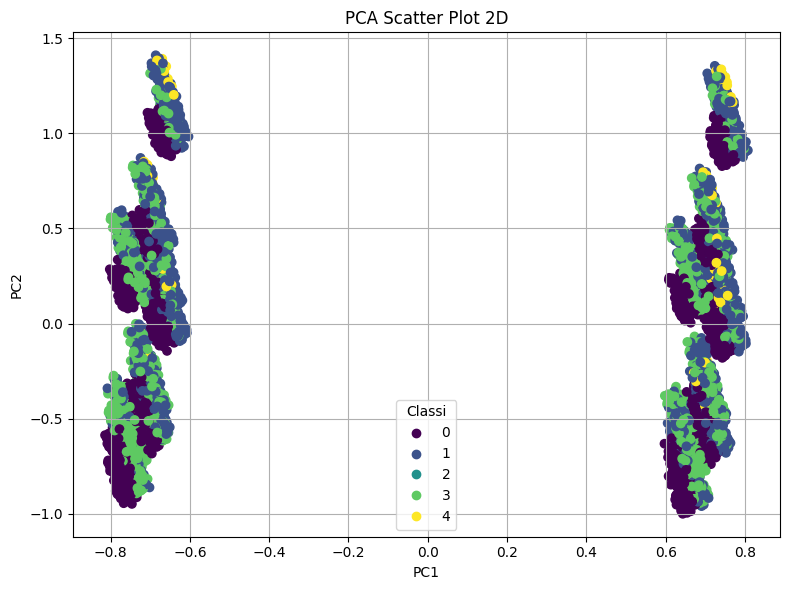

Le prime 2 PC spiegano il 15.46% della varianza


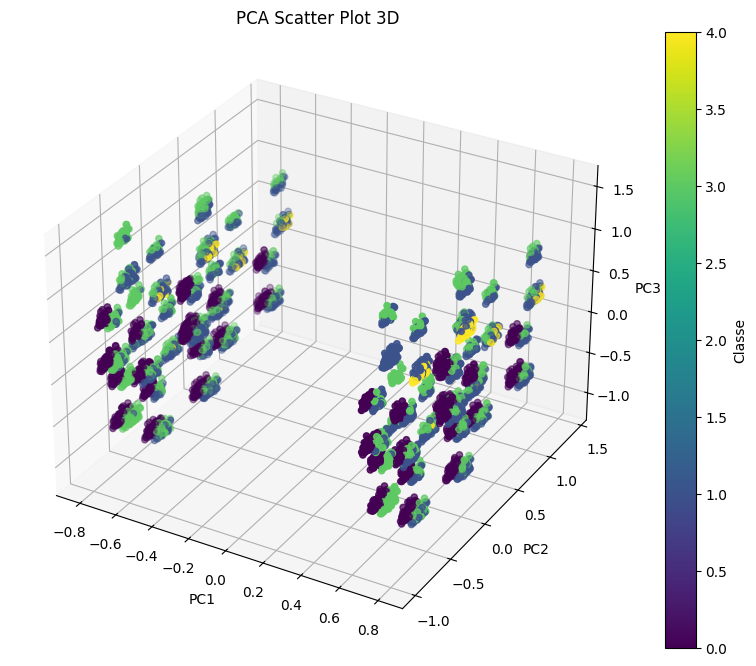

Le prime 3 PC spiegano il 21.70% della varianza


In [9]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c = y_train)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Scatter Plot 2D")
plt.legend(*scatter.legend_elements(), title="Classi")
plt.grid(True)
plt.tight_layout()
plt.show()
print(f"Le prime 2 PC spiegano il {varianza_spiegata[0]*100+varianza_spiegata[1]*100:.2f}% della varianza")

# Grafico 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c = y_train)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA Scatter Plot 3D")
plt.colorbar(scatter, label="Classe")
plt.show()
print(f"Le prime 3 PC spiegano il {varianza_totale*100:.2f}% della varianza")

# Barplot


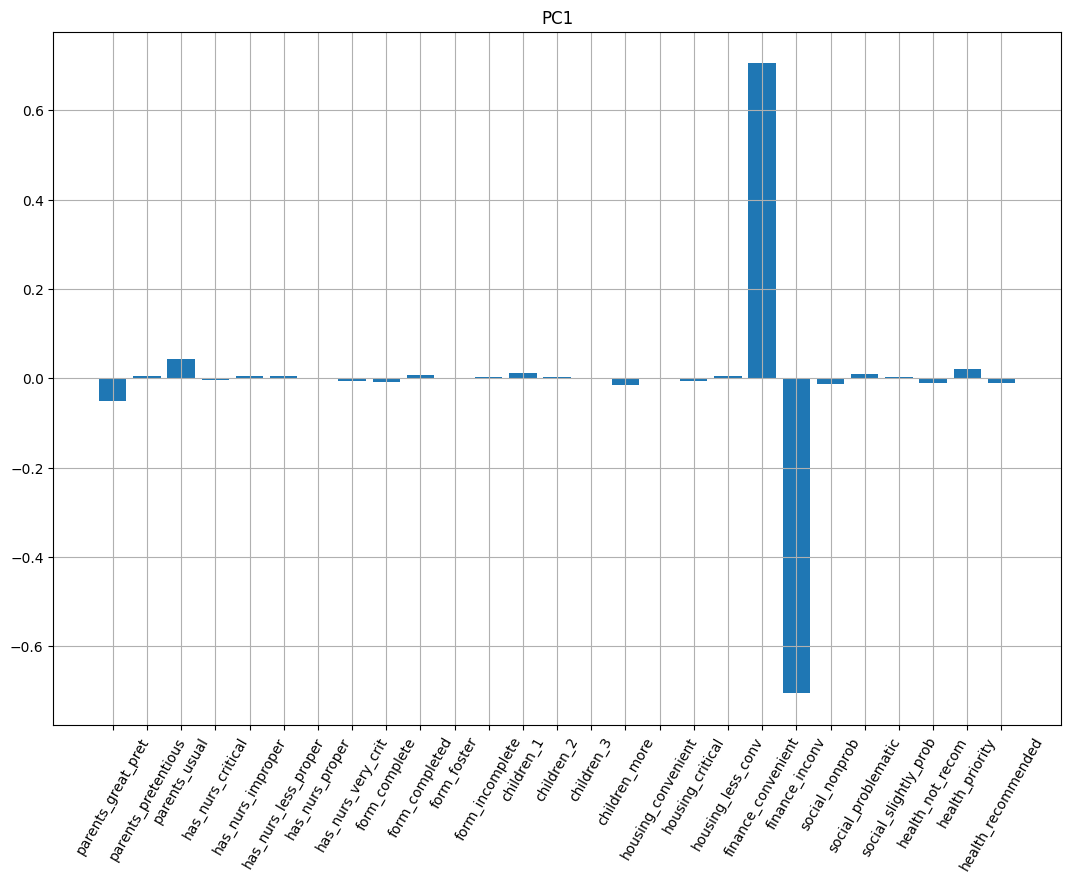

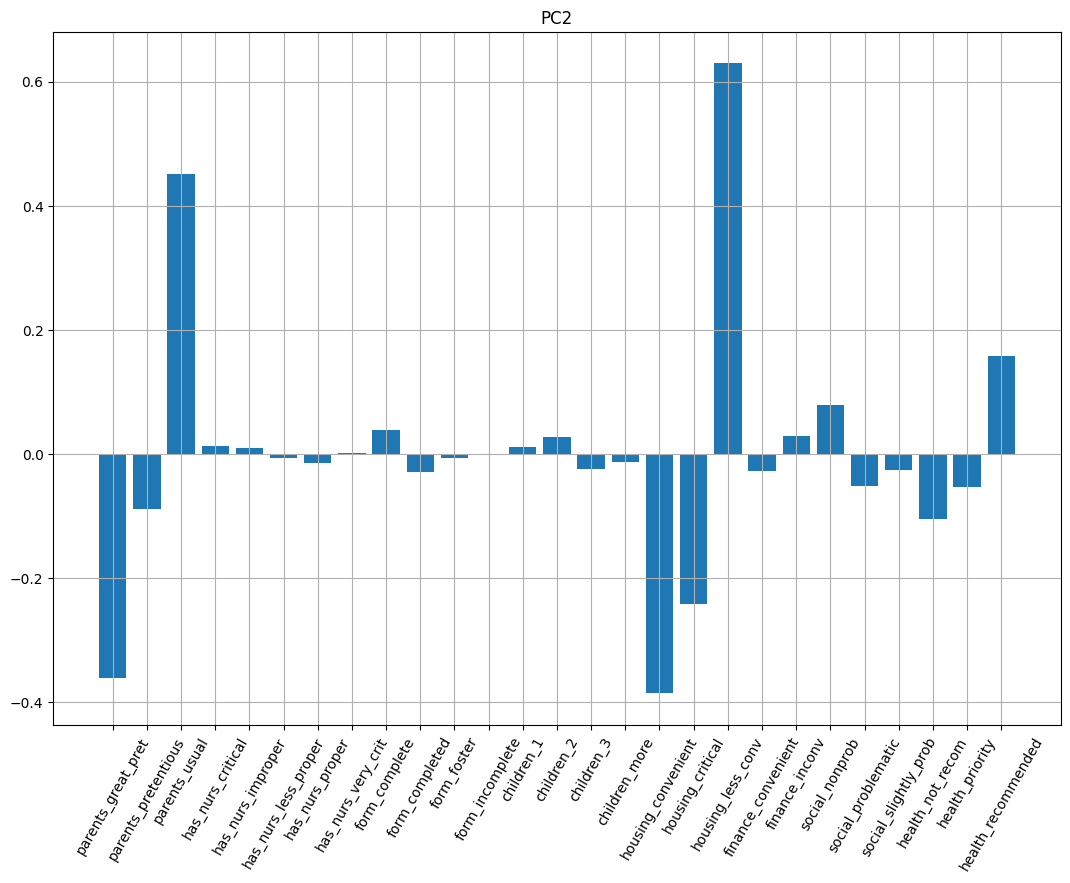

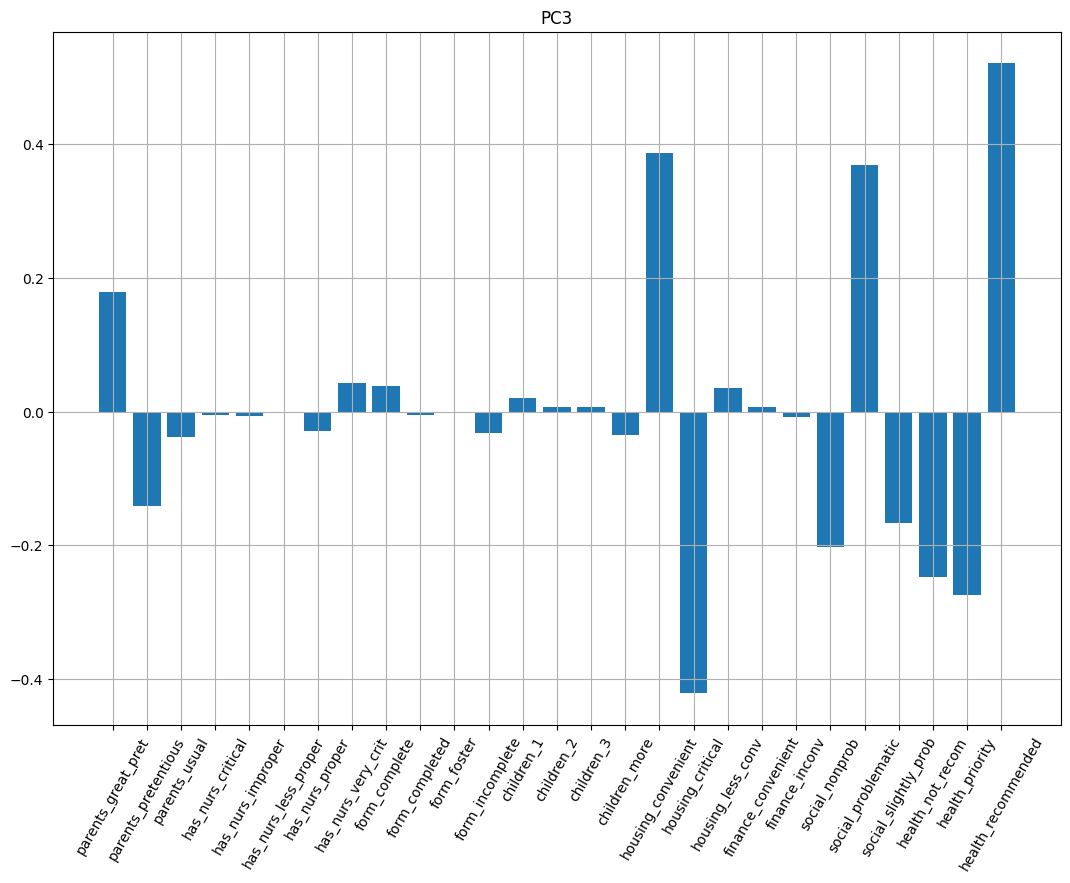

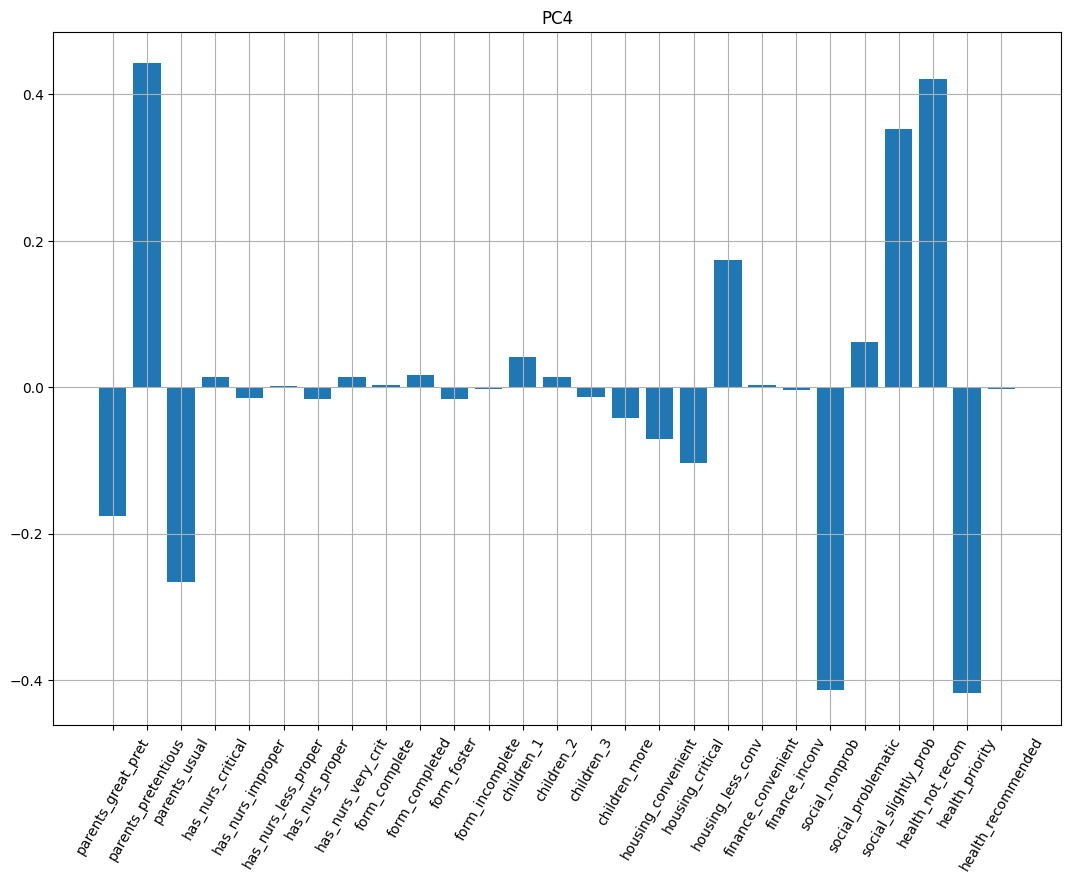

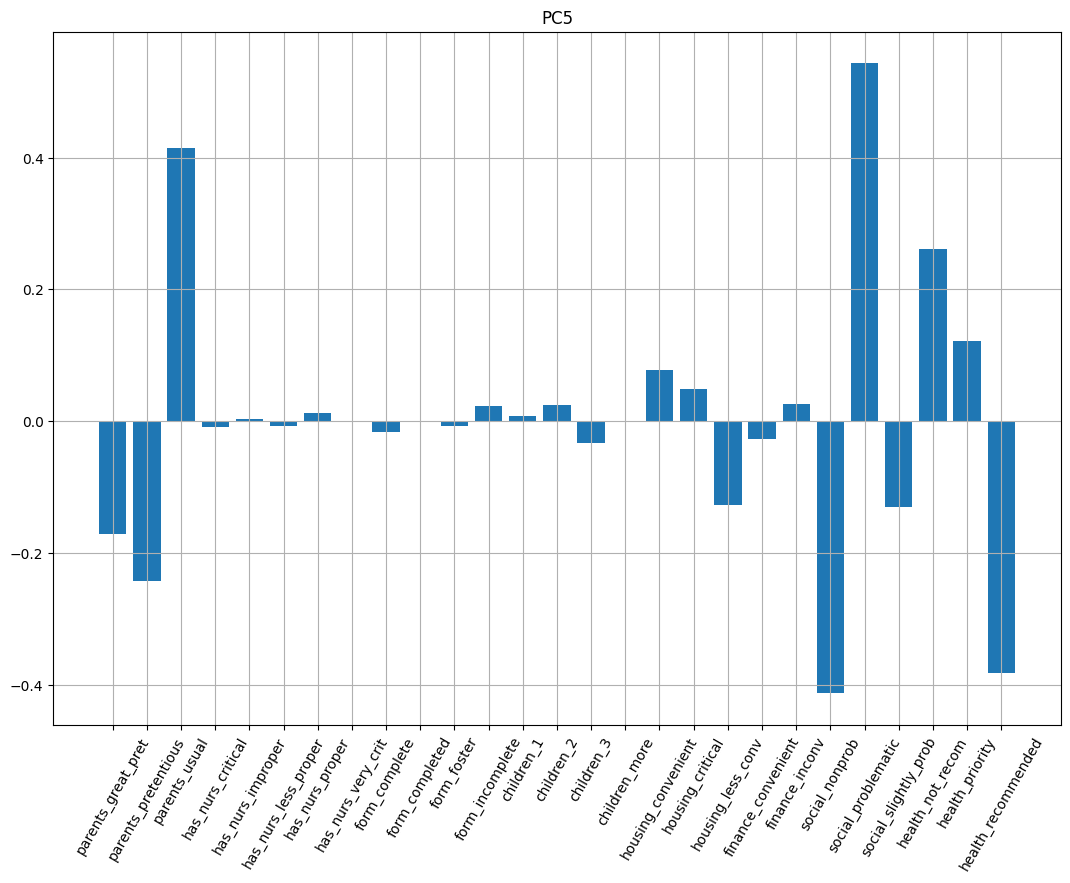

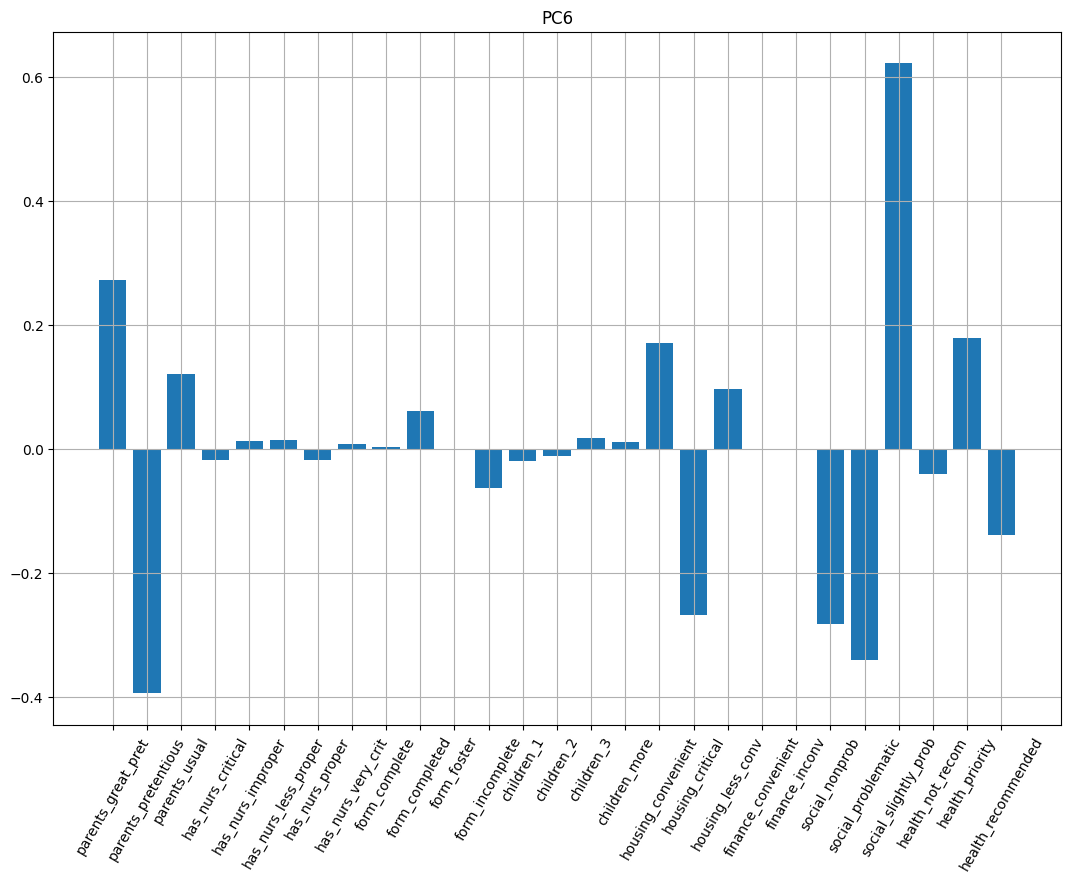

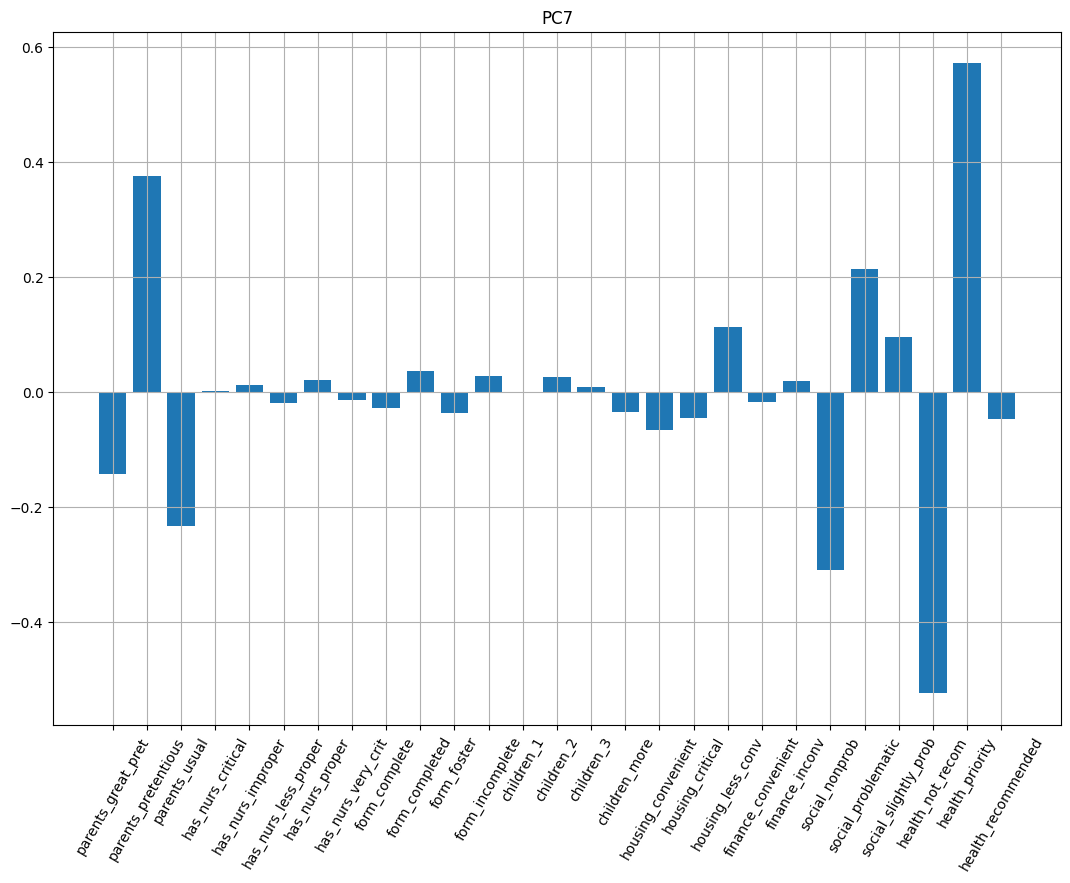

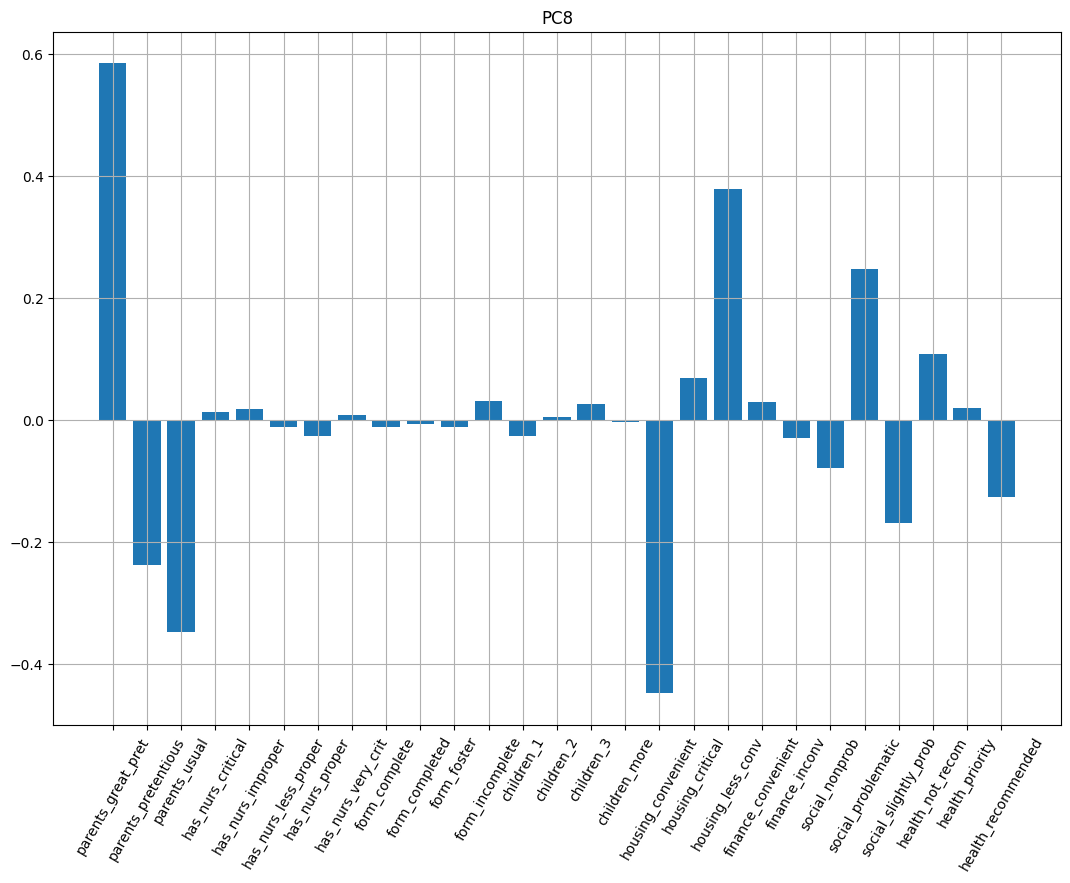

In [10]:
plt.figure(figsize = (13,9))
plt.bar(np.arange(len(pca.components_[0])), pca.components_[0,:])
plt.xticks(ticks = np.arange(len(pca.components_[0])),
           labels = nursery_dataframe.columns.to_list()[1:],
           rotation = 60)
plt.title("PC1")
plt.grid()
plt.show()

plt.figure(figsize = (13,9))
plt.bar(np.arange(len(pca.components_[0])), pca.components_[1,:])
plt.xticks(ticks = np.arange(len(pca.components_[0])),
           labels = nursery_dataframe.columns.to_list()[1:],
           rotation = 60)
plt.title("PC2")
plt.grid()
plt.show()

plt.figure(figsize = (13,9))
plt.bar(np.arange(len(pca.components_[0])), pca.components_[2,:])
plt.xticks(ticks = np.arange(len(pca.components_[0])),
           labels = nursery_dataframe.columns.to_list()[1:],
           rotation = 60)
plt.title("PC3")
plt.grid()
plt.show()

plt.figure(figsize = (13,9))
plt.bar(np.arange(len(pca.components_[0])), pca.components_[3,:])
plt.xticks(ticks = np.arange(len(pca.components_[0])),
           labels = nursery_dataframe.columns.to_list()[1:],
           rotation = 60)
plt.title("PC4")
plt.grid()
plt.show()

plt.figure(figsize = (13,9))
plt.bar(np.arange(len(pca.components_[0])), pca.components_[4,:])
plt.xticks(ticks = np.arange(len(pca.components_[0])),
           labels = nursery_dataframe.columns.to_list()[1:],
           rotation = 60)
plt.title("PC5")
plt.grid()
plt.show()

plt.figure(figsize = (13,9))
plt.bar(np.arange(len(pca.components_[0])), pca.components_[5,:])
plt.xticks(ticks = np.arange(len(pca.components_[0])),
           labels = nursery_dataframe.columns.to_list()[1:],
           rotation = 60)
plt.title("PC6")
plt.grid()
plt.show()

plt.figure(figsize = (13,9))
plt.bar(np.arange(len(pca.components_[0])), pca.components_[6,:])
plt.xticks(ticks = np.arange(len(pca.components_[0])),
           labels = nursery_dataframe.columns.to_list()[1:],
           rotation = 60)
plt.title("PC7")
plt.grid()
plt.show()

plt.figure(figsize = (13,9))
plt.bar(np.arange(len(pca.components_[0])), pca.components_[7,:])
plt.xticks(ticks = np.arange(len(pca.components_[0])),
           labels = nursery_dataframe.columns.to_list()[1:],
           rotation = 60)
plt.title("PC8")
plt.grid()
plt.show()

<h1>LDA - Linear Discriminant Analysis</h1>

<p>La LDA è una tecnica di classificazione supervisionata che unisce riduzione dimensionale e discriminazione tra classi in un unico modello lineare. A differenza di metodi come la PCA, che ignorano le etichette e cercano direzioni di massima varianza globale, la LDA proietta i dati in uno spazio a dimensionalità ridotta cercando di massimizzare la varianza tra classi e minimizzare quella all’interno delle classi.</p>

Il metodo LDA si basa sul teorema di Bayes per classificare i dati tramite bordi di decisione lineari. Le ipotesi principali sono:
<ul>
    <li>le distribuzioni delle classi sono normali multivariate;</li>
    <li>tutte le classi hanno la stessa matrice di covarianza (omoschedasticità).</li>
</ul>

LDA calcola per ogni classe $k = 1, \ldots, c$ una funzione discriminante:

$$
\delta_k(\boldsymbol{x}) = \boldsymbol{x}^T S^{-1} \boldsymbol{\mu}_k - \frac{1}{2} \boldsymbol{\mu}_k^T S^{-1} \boldsymbol{\mu}_k + \log \pi_k
$$

dove:
<ul>
    <li>$\boldsymbol{x}$ è il vettore da classificare;</li>
    <li>$\boldsymbol{\mu}_k$ è la media della classe $k$;</li>
    <li>$S$ è la matrice di covarianza comune a tutte le classi;</li>
    <li>$\pi_k$ è la probabilità a priori di appartenere alla classe $k$.</li>
</ul>

La classificazione consiste nell’assegnare $\boldsymbol{x}$ alla classe con valore massimo di $\delta_k(\boldsymbol{x})$.

Questa formula deriva dal teorema di Bayes:

$$
P(Y = k \mid \boldsymbol{x}) = \frac{\pi_k f_k(\boldsymbol{x})}{\sum_{i=1}^c \pi_i f_i(\boldsymbol{x})}
$$

dove $f_k(\boldsymbol{x})$ è la densità di probabilità della normale multivariata con media $\boldsymbol{\mu}_k$ e matrice di covarianza $S$:

$$
f_k(\boldsymbol{x}) = \frac{1}{(2\pi)^{n/2} \sqrt{|S|}} \exp\left( -\frac{1}{2} (\boldsymbol{x} - \boldsymbol{\mu}_k)^T S^{-1} (\boldsymbol{x} - \boldsymbol{\mu}_k) \right)
$$

Applicando il logaritmo e scartando i termini indipendenti da $k$, si ottiene la funzione $\delta_k(\boldsymbol{x})$.


Nella pratica, i parametri sono stimati dai dati:
<ul>
    <li>$\hat{\pi}_k = \frac{N_k}{N}$, con $N_k$ numero di elementi della classe $k$;</li>
    <li>$\hat{\boldsymbol{\mu}}_k = \frac{1}{N_k} \sum_{\boldsymbol{x} \in \text{classe } k} \boldsymbol{x}$;</li>
    <li>$\hat{S} = \sum_{k=1}^c \frac{N_k - 1}{N - c} \hat{S}_k$, con $\hat{S}_k$ matrice di covarianza campionaria della classe $k$.</li>
</ul>

Una volta stimate le funzioni $\hat{\delta}_k$, è possibile ottenere una stima approssimata della probabilità a posteriori:

$$
\hat{P}(Y = k \mid \boldsymbol{x}) = \frac{e^{\hat{\delta}_k(\boldsymbol{x})}}{\sum_{i=1}^c e^{\hat{\delta}_i(\boldsymbol{x})}}
$$


Infine, LDA può essere interpretata anche geometricamente: i dati vengono proiettati in uno spazio di dimensione $c - 1$ generato dai vettori medi delle classi, e la classificazione si fa trovando il centroide più vicino al punto proiettato.

# Grafico LDA 2D su dati originali e su dati PCA-ridotti #

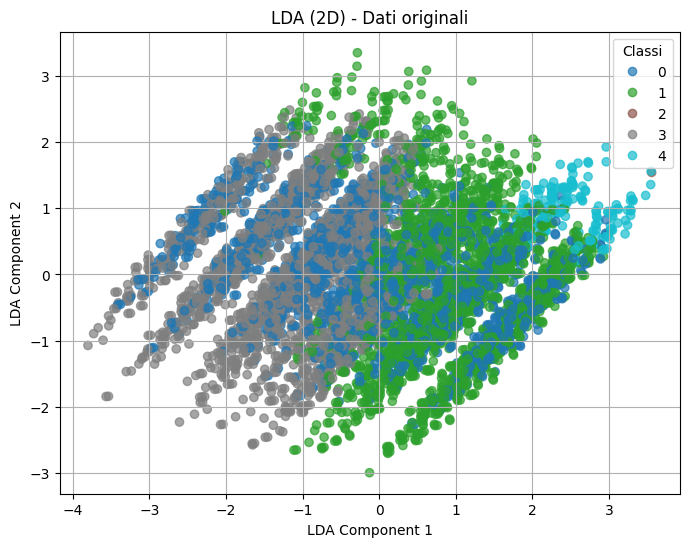

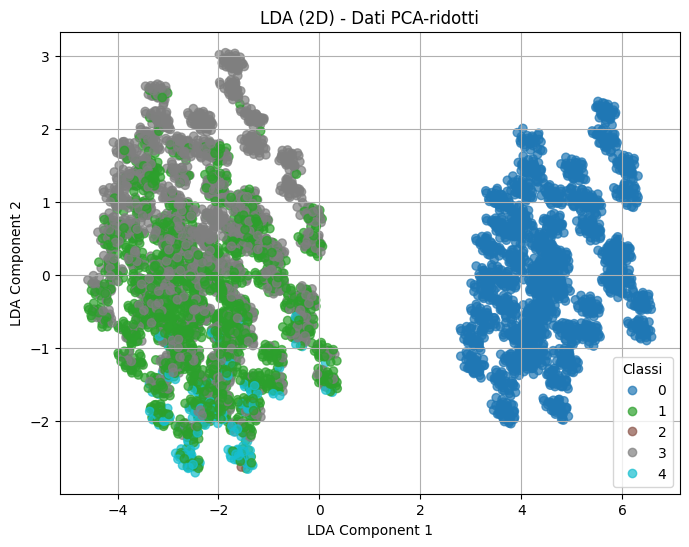

In [11]:
lda_vis = LDA(n_components=2)
X_lda_2d = lda_vis.fit_transform(X_train, y_train)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_lda_2d[:, 0], X_lda_2d[:, 1], c=y_train, cmap='tab10', alpha=0.7)
plt.title("LDA (2D) - Dati originali")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.legend(*scatter.legend_elements(), title="Classi")
plt.grid(True)
plt.show()

lda_vis_pca = LDA(n_components=2)
X_lda_2d_pca = lda_vis_pca.fit_transform(X_train_pca, y_train)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_lda_2d_pca[:, 0], X_lda_2d_pca[:, 1], c=y_train, cmap='tab10', alpha=0.7)
plt.title("LDA (2D) - Dati PCA-ridotti")
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.legend(*scatter.legend_elements(), title="Classi")
plt.grid(True)
plt.show()

# Grafici LDA 3D su dati originali e su dati PCA-ridotti #

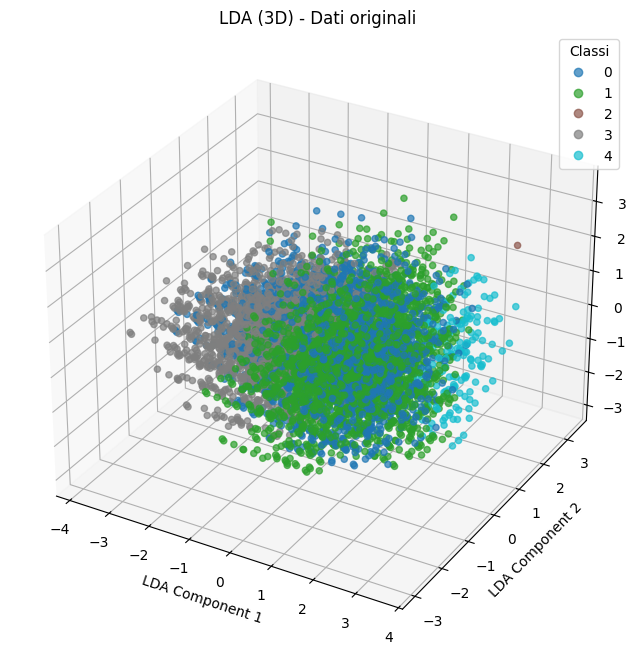

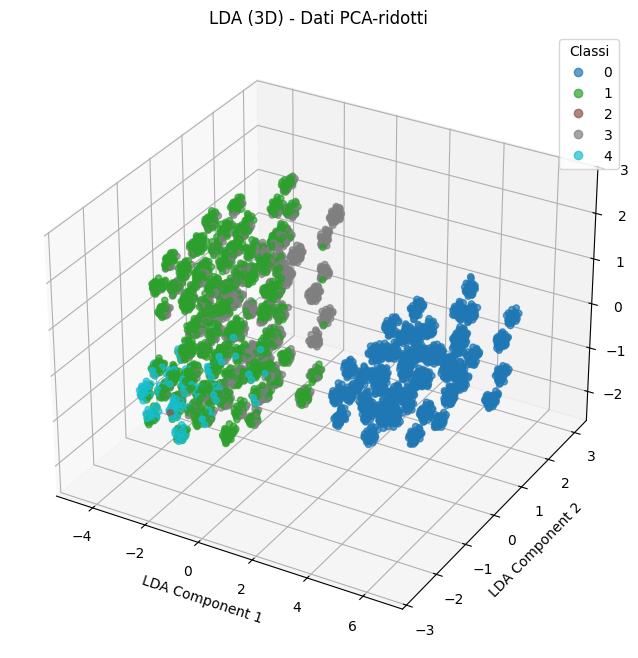

In [12]:
lda_3d = LDA(n_components=3)
X_lda_3d = lda_3d.fit_transform(X_train, y_train)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_lda_3d[:, 0], X_lda_3d[:, 1], X_lda_3d[:, 2], 
                     c=y_train, cmap='tab10', alpha=0.7)
ax.set_title("LDA (3D) - Dati originali")
ax.set_xlabel("LDA Component 1")
ax.set_ylabel("LDA Component 2")
ax.set_zlabel("LDA Component 3")
legend = ax.legend(*scatter.legend_elements(), title="Classi", loc="best")
plt.show()

lda_3d_pca = LDA(n_components=3)
X_lda_3d_pca = lda_3d_pca.fit_transform(X_train_pca, y_train)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_lda_3d_pca[:, 0], X_lda_3d_pca[:, 1], X_lda_3d_pca[:, 2], 
                     c=y_train, cmap='tab10', alpha=0.7)
ax.set_title("LDA (3D) - Dati PCA-ridotti")
ax.set_xlabel("LDA Component 1")
ax.set_ylabel("LDA Component 2")
ax.set_zlabel("LDA Component 3")
legend = ax.legend(*scatter.legend_elements(), title="Classi", loc="best")
plt.show()

,Training Set,Test Set
Accuracy,0.541512,0.550617
Precision,0.533220,0.541889
Recall,0.541512,0.550617
F1-score,0.528887,0.537836


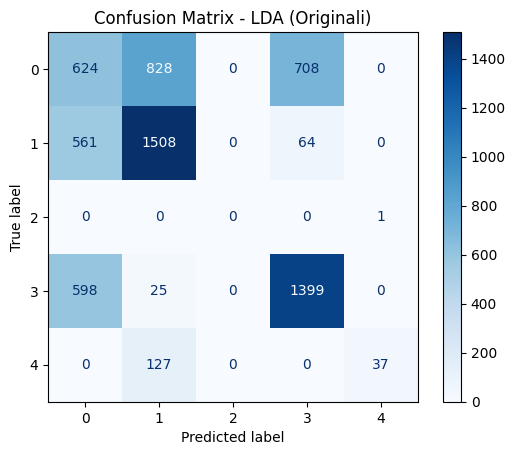

,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
0,0,43.25,18.20,0.0,38.51,0.05
1,3,35.93,13.27,0.0,50.79,0.01
2,1,42.13,43.76,0.0,13.87,0.25
3,3,20.01,2.84,0.0,77.14,0.00
4,3,32.78,7.45,0.0,59.72,0.06
...,...,...,...,...,...,...
6475,3,10.12,0.63,0.0,89.25,0.00
6476,3,37.89,10.65,0.0,51.43,0.02
6477,0,46.35,34.18,0.0,19.11,0.36
6478,0,44.40,35.89,0.0,19.65,0.06


In [14]:
lda = LDA()

[LDA_score, LDA_score_test] = evaluate_and_plot(lda, X_train, y_train, X_test, y_test, name = "LDA (Originali)")

,Training Set,Test Set
Accuracy,0.773611,0.774074
Precision,0.757937,0.758039
Recall,0.773611,0.774074
F1-score,0.764987,0.765506


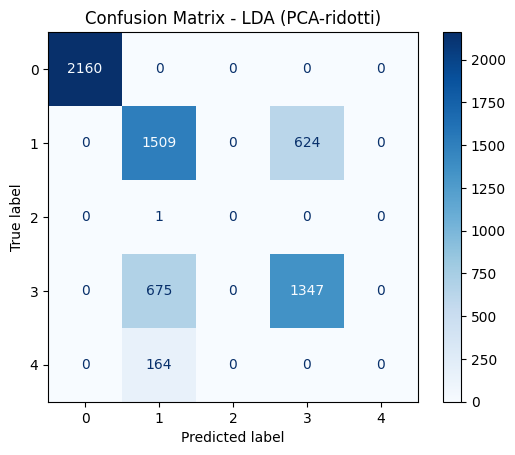

,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
0,0,100.0,0.00,0.00,0.00,0.00
1,0,100.0,0.00,0.00,0.00,0.00
2,3,0.0,23.42,0.00,76.52,0.06
3,3,0.0,23.40,0.00,76.48,0.12
4,1,0.0,57.27,0.00,35.54,7.18
...,...,...,...,...,...,...
6475,0,100.0,0.00,0.00,0.00,0.00
6476,0,100.0,0.00,0.00,0.00,0.00
6477,1,0.0,70.31,0.07,10.19,19.42
6478,0,100.0,0.00,0.00,0.00,0.00


In [15]:
[LDA_score_PCA, LDA_score_test_PCA] = evaluate_and_plot(lda, X_train_pca, y_train, X_test_pca, y_test, name = "LDA (PCA-ridotti)")

<h1>SVM - Support Vector Machine</h1>

<p>La SVM nasce come classificatore binario in quanto separa i dati in due classi trovando un iperpiano ottimale che massimizza il margine tra i punti delle due categorie.Quando però il problema coinvolge più di due classi, la SVM viene estesa tramite strategie multiclasse, che costruiscono più classificatori binari e li combinano. Nel nostro caso, avendo 5 classi, utilizziamo la strategia One-vs-One (OvO) che costruisce una SVM per ogni coppia di classi, per poi mettere insieme tutti i risultati</p>

<p>
Le Support Vector Machine (SVM) sono algoritmi di apprendimento supervisionato molto potenti, utilizzati principalmente per la classificazione, ma anche per la regressione. 
L'idea di base è semplice: trovare una frontiera (un iperpiano) che separi nel modo migliore possibile i punti di due classi. 
Ma cosa significa "nel modo migliore"? Significa che vogliamo trovare l'iperpiano che crea il maggior <strong>margine</strong> tra le due classi, ovvero la distanza più ampia possibile tra i punti più vicini all’iperpiano (i cosiddetti <em>support vectors</em>) da ciascun lato.
</p>

<p>
Questa scelta non è casuale: un margine ampio riduce il rischio di overfitting, migliorando la capacità del modello di generalizzare a nuovi dati.
</p>

<h2>SVM Lineare - Dati Separabili</h2>

<p>
Partiamo dal caso ideale in cui i dati sono linearmente separabili, ovvero esiste un iperpiano che divide perfettamente i punti delle due classi. 
Abbiamo un insieme di dati:
</p>

<p>
\[
\mathcal{T} = \{ (\boldsymbol{x}_i, y_i) \in \mathbb{R}^n \times \{-1, +1\} \mid i = 1, \dots, T \}
\]
</p>

<p>
L’obiettivo è trovare un iperpiano definito da:
</p>

<p>
\[
\Pi_{\boldsymbol{w}, b} = \{ \boldsymbol{x} \in \mathbb{R}^n : \boldsymbol{w}^T \boldsymbol{x} + b = 0 \}
\]
</p>

<p>
che separa le due classi con il margine massimo.
</p>

<h3>Margine Geometrico</h3>

<p>
La distanza di un punto qualsiasi \(\boldsymbol{x}\) dall’iperpiano è data dalla formula:
</p>

<p>
\[
\mathrm{dist}(\Pi_{\boldsymbol{w}, b}, \boldsymbol{x}) = \frac{|\boldsymbol{w}^T \boldsymbol{x} + b|}{\|\boldsymbol{w}\|}
\]
</p>

<p>
Per i punti più vicini — i support vectors — imponiamo che siano a distanza esattamente 1 dal margine, da entrambi i lati. 
In tal caso, la distanza complessiva tra i due margini (uno per classe) è:
</p>

<p>
\[
M = \frac{2}{\|\boldsymbol{w}\|}
\]
</p>

<p>
Quindi, massimizzare il margine equivale a minimizzare \(\|\boldsymbol{w}\|\), rendendo il problema un’ottimizzazione con vincoli.
</p>

<h3>Problema Primal</h3>

<p>
Il problema di ottimizzazione si scrive allora come:
</p>

<p>
\[
\begin{aligned}
\min_{\boldsymbol{w}, b} \quad & \frac{1}{2} \|\boldsymbol{w}\|^2 \\
\text{s.t.} \quad & y_i (\boldsymbol{w}^T \boldsymbol{x}_i + b) \geq 1 \quad \forall i
\end{aligned}
\]
</p>

<p>
Il termine \( \frac{1}{2} \|\boldsymbol{w}\|^2 \) è scelto per convenienza matematica, essendo convesso e derivabile. Questo problema è un classico caso di ottimizzazione quadratica convessa con vincoli lineari.
</p>

<h3>Problema Duale</h3>

<p>
Per risolvere il problema in modo efficiente e, soprattutto, per estenderlo ai casi non lineari, si passa alla forma <strong>duale</strong> con i moltiplicatori di Lagrange \(\alpha_i\). Il problema diventa:
</p>

<p>
\[
\begin{aligned}
\max_{\boldsymbol{\alpha}} \quad & \sum_{i=1}^T \alpha_i - \frac{1}{2} \sum_{i,j=1}^T \alpha_i \alpha_j y_i y_j \boldsymbol{x}_i^T \boldsymbol{x}_j \\
\text{s.t.} \quad & \sum_{i=1}^T \alpha_i y_i = 0, \quad \alpha_i \geq 0 \ \forall i
\end{aligned}
\]
</p>

<p>
La bellezza di questa formulazione è che si basa solo sui prodotti scalari tra dati. Questo sarà cruciale per usare i <em>kernel</em>.
</p>

<h3>Soluzione del Problema</h3>

<p>
Una volta risolto il problema duale e ottenuti i coefficienti \(\alpha_i^*\), il vettore dei pesi è:
</p>

<p>
\[
\boldsymbol{w}^* = \sum_{i=1}^T \alpha_i^* y_i \boldsymbol{x}_i
\]
</p>

<p>
Il termine di bias si ottiene calcolando la media sui support vectors:
</p>

<p>
\[
b^* = \frac{1}{|\mathcal{I}_{\text{sv}}|} \sum_{i \in \mathcal{I}_{\text{sv}}} \left( y_i - \boldsymbol{w}^{*T} \boldsymbol{x}_i \right)
\]
</p>

<p>
dove \(\mathcal{I}_{\text{sv}}\) è l’insieme degli indici dei support vectors (i cui \(\alpha_i^* > 0\)).
</p>

<h2>Soft Margin (Margine Morbido)</h2>

<p>
Nel mondo reale, i dati sono raramente separabili perfettamente. Per questo motivo si introduce il concetto di <strong>soft margin</strong>, che permette al modello di tollerare alcuni errori attraverso delle variabili di slack \(\xi_i \geq 0\):
</p>

<p>
\[
\begin{aligned}
\min_{\boldsymbol{w}, b, \boldsymbol{\xi}} \quad & \frac{1}{2} \|\boldsymbol{w}\|^2 + C \sum_{i=1}^T \xi_i \\
\text{s.t.} \quad & y_i (\boldsymbol{w}^T \boldsymbol{x}_i + b) \geq 1 - \xi_i \\
& \xi_i \geq 0
\end{aligned}
\]
</p>

<ul>
    <li>Il parametro <strong>C</strong> controlla il compromesso tra un margine più ampio e la penalizzazione degli errori.</li>
    <li>Valori alti di \(C\) danno priorità alla classificazione corretta (margine rigido).</li>
    <li>Valori piccoli di \(C\) accettano più errori per ottenere un margine più ampio (margine più morbido).</li>
</ul>

<h2>SVM Non Lineare e Kernel Trick</h2>

<p>
Quando i dati non sono linearmente separabili nemmeno con un soft margin, si può usare il <strong>kernel trick</strong>: 
invece di cercare una separazione nello spazio originale, si mappa ogni punto in uno spazio di dimensione superiore dove la separazione è possibile:
</p>

<p>
\[
\phi: \mathbb{R}^n \to \mathcal{H}
\]
</p>

<p>
Per evitare di calcolare esplicitamente \(\phi(\boldsymbol{x})\), si definisce un <strong>kernel</strong> che restituisce il prodotto scalare nello spazio trasformato:
</p>

<p>
\[
K(\boldsymbol{x}_i, \boldsymbol{x}_j) = \phi(\boldsymbol{x}_i)^T \phi(\boldsymbol{x}_j)
\]
</p>

<h3>Kernel RBF (Radial Basis Function)</h3>

<p>
Uno dei kernel più utilizzati è il <strong>RBF (Gaussiano)</strong>, definito come:
</p>

<p>
\[
K(\boldsymbol{x}_i, \boldsymbol{x}_j) = \exp\left(-\gamma \|\boldsymbol{x}_i - \boldsymbol{x}_j\|^2\right)
\]
</p>

<p>
Questo kernel crea uno spazio di dimensione infinita in cui punti anche molto complessi possono essere separati. Il parametro \(\gamma\) regola l'influenza di ciascun punto di training:
</p>

<ul>
    <li>Un valore grande di \(\gamma\) crea confini molto precisi, ma può portare a overfitting.</li>
    <li>Un valore piccolo di \(\gamma\) genera decisioni più lisce e generalizzabili.</li>
</ul>

<h3>Funzione Decisionale</h3>

<p>
La funzione finale usata per classificare un nuovo punto \(\boldsymbol{x}\) è:
</p>

<p>
\[
f(\boldsymbol{x}) = \sum_{i=1}^T \alpha_i^* y_i K(\boldsymbol{x}_i, \boldsymbol{x}) + b^*
\]
</p>

<p>
Il segno di \(f(\boldsymbol{x})\) determina l’etichetta della classe assegnata al punto. 
Questo permette di ottenere separazioni altamente non lineari nel piano originale, pur mantenendo un modello lineare nello spazio trasformato.
</p>

,Training Set,Test Set
Accuracy,0.930710,0.933796
Precision,0.930464,0.933378
Recall,0.930710,0.933796
F1-score,0.930550,0.933517


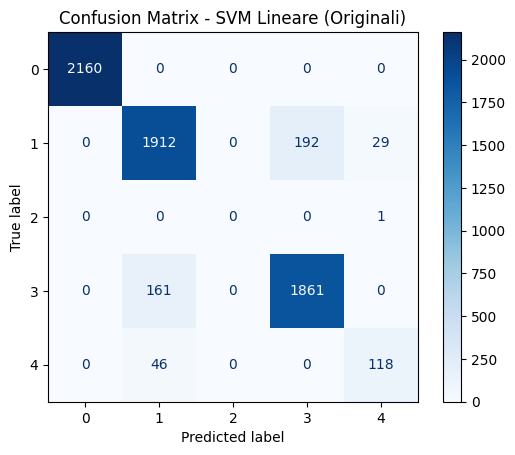

,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
0,0,99.90,0.03,0.01,0.05,0.02
1,0,99.90,0.02,0.02,0.05,0.02
2,1,0.03,91.44,0.02,8.51,0.01
3,3,0.02,0.19,0.01,99.78,0.00
4,3,0.03,1.82,0.02,98.14,0.00
...,...,...,...,...,...,...
6475,0,99.90,0.02,0.01,0.05,0.02
6476,0,99.91,0.02,0.01,0.05,0.02
6477,1,0.08,71.93,0.07,25.19,2.73
6478,0,99.89,0.04,0.01,0.04,0.02


In [16]:
svc_linear = SVC(kernel='linear', C = 2, probability=True, random_state = 42)

[SVMl_score, SVMl_score_test] = evaluate_and_plot(svc_linear, X_train, y_train, X_test, y_test, name = "SVM Lineare (Originali)")

,Training Set,Test Set
Accuracy,0.755864,0.748765
Precision,0.751287,0.743074
Recall,0.755864,0.748765
F1-score,0.742795,0.735925


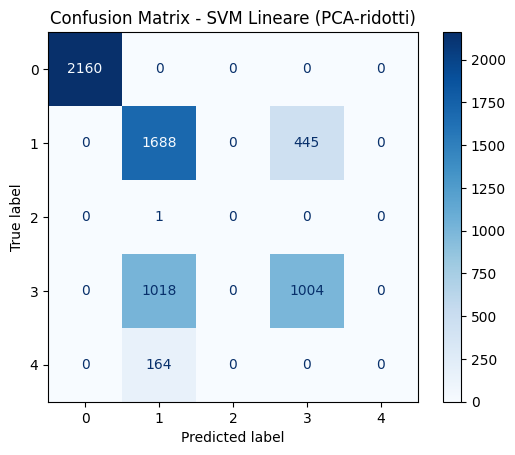

,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
0,0,99.75,0.08,0.03,0.07,0.08
1,0,99.69,0.11,0.02,0.19,0.00
2,3,0.00,26.95,0.01,73.03,0.00
3,3,0.01,24.13,0.01,75.85,0.00
4,3,0.01,30.09,0.04,69.87,0.00
...,...,...,...,...,...,...
6475,0,99.99,0.00,0.01,0.00,0.00
6476,0,99.69,0.10,0.03,0.10,0.08
6477,1,0.22,59.19,0.22,19.65,20.72
6478,0,99.80,0.07,0.02,0.12,0.00


In [17]:
[SVMl_score_PCA, SVMl_score_test_PCA] = evaluate_and_plot(svc_linear, X_train_pca, y_train, X_test_pca, y_test, name = "SVM Lineare (PCA-ridotti)")

,Training Set,Test Set
Accuracy,0.999846,0.999846
Precision,0.999692,0.999692
Recall,0.999846,0.999846
F1-score,0.999769,0.999769


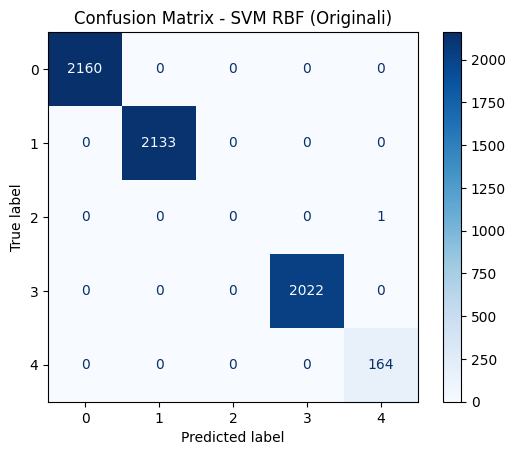

,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
0,0,99.90,0.02,0.01,0.05,0.02
1,0,99.89,0.02,0.02,0.05,0.02
2,1,0.00,99.99,0.01,0.00,0.00
3,3,0.00,0.00,0.00,100.00,0.00
4,1,0.00,99.93,0.01,0.06,0.00
...,...,...,...,...,...,...
6475,0,99.90,0.02,0.01,0.05,0.02
6476,0,99.90,0.02,0.02,0.05,0.02
6477,1,0.00,99.83,0.02,0.16,0.00
6478,0,99.90,0.05,0.02,0.02,0.02


In [18]:
svc_rbf = SVC(kernel = 'rbf', C = 2, gamma = 'scale', probability = True, random_state = 42)

[SVMnl_score, SVMnl_score_test] = evaluate_and_plot(svc_rbf, X_train, y_train, X_test, y_test, name = "SVM RBF (Originali)")

,Training Set,Test Set
Accuracy,0.788117,0.776080
Precision,0.790414,0.777514
Recall,0.788117,0.776080
F1-score,0.785168,0.773876


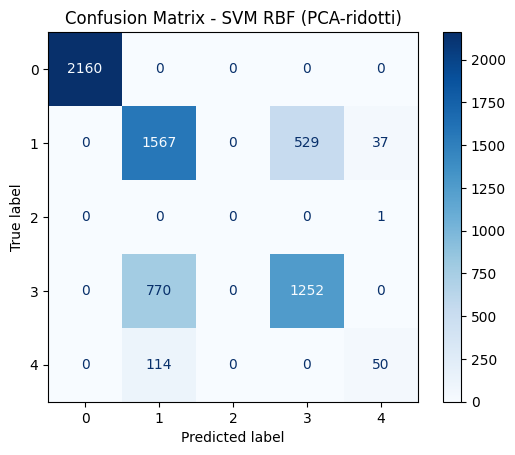

,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
0,0,99.88,0.04,0.02,0.04,0.02
1,0,99.74,0.08,0.02,0.12,0.03
2,3,0.04,26.14,0.01,73.52,0.28
3,3,0.09,24.53,0.01,75.03,0.34
4,1,0.19,71.43,0.02,25.48,2.88
...,...,...,...,...,...,...
6475,0,99.99,0.00,0.01,0.00,0.00
6476,0,99.90,0.03,0.02,0.03,0.02
6477,1,1.01,72.92,0.79,14.60,10.68
6478,0,99.82,0.05,0.02,0.08,0.03


In [19]:
[SVMnl_score_PCA, SVMnl_score_test_PCA] = evaluate_and_plot(svc_rbf, X_train_pca, y_train, X_test_pca, y_test, name = "SVM RBF (PCA-ridotti)")

<h1>MLP - Multi-Layer Perceptron</h1>

<p>I <strong>Multi-Layer Perceptron</strong> (MLP) sono un tipo di rete neurale feedforward, composti da una sequenza di <em>fully-connected layers</em> (FC layers).</p>

<h2>Definizione di Fully-Connected Layer</h2>

<p>Un livello fully-connected con $m$ unità e attivazione $\sigma:\mathbb{R} \to \mathbb{R}$ connesso a un livello precedente di $n$ unità è descritto dalla funzione $ \mathcal{L}:\mathbb{R}^n\rightarrow\mathbb{R}^m $:</p>

$$
\mathcal{L}(\boldsymbol{x}) = \boldsymbol{\sigma}(W \boldsymbol{x} + \boldsymbol{b}), \quad \forall \boldsymbol{x} \in \mathbb{R}^n
$$

<p>dove:</p>
<ul>
  <li>$W \in \mathbb{R}^{m \times n}$ è la matrice dei pesi,</li>
  <li>$\boldsymbol{b} \in \mathbb{R}^m$ è il vettore dei bias,</li>
  <li>$\boldsymbol{\sigma}$: applica $\sigma$ elemento per elemento.</li>
</ul>

<h2>Definizione di Input Layer</h2>

<p>Un input layer con $n$ unità riceve input da $\mathbb{R}^n$ e lo trasmette ai layer successivi.</p>

<h2>Funzione complessiva di un MLP</h2>

<p>Un MLP con input layer $L^{(0)}$, $H$ hidden layers $L^{(1)}, \ldots, L^{(H)}$ e output layer $L^{(H+1)}$ realizza una funzione:</p>

$$
\hat{\boldsymbol{F}}(\boldsymbol{x}) : \mathbb{R}^n \rightarrow \mathbb{R}^m
$$

<p>composta come:</p>

$$
\hat{\boldsymbol{F}}(\boldsymbol{x}) = \boldsymbol{\sigma}^{(H+1)} \left( W^{(H+1)} \cdots \boldsymbol{\sigma}^{(1)}(W^{(1)} \boldsymbol{x} + \boldsymbol{b}^{(1)}) \cdots + \boldsymbol{b}^{(H+1)} \right)
$$

<strong>COPIARE DA MLP</strong>

<p>dove:</p>
<ul>
  <li>$W^{(h)}$, $\boldsymbol{b}^{(h)}$, $\sigma^{(h)}$ sono i pesi, bias e funzioni di attivazione del layer $h$-esimo,</li>
  <li>$n_h$ è il numero di unità del layer $h$,</li>
  <li>$\boldsymbol{x}^{(h)}$ è l’output del layer $h$ dato $\boldsymbol{x}$,</li>
  <li>$m$ è il numero di unità dell’output layer.</li>
</ul>

<h2>Metodi di Discesa del Gradiente</h2>

<p>Questi metodi minimizzano una funzione $f:\mathbb{R}^n \rightarrow \mathbb{R}$ sfruttando il fatto che $-\nabla f(\boldsymbol{x}_0)$ è direzione di massima discesa.</p>

<h3>Direzione di discesa</h3>

<p>Un vettore $\boldsymbol{p}$ è direzione di discesa per $f$ in $\boldsymbol{x}_0$ se:</p>

$$
\exists \, \alpha^*>0 \text{ tale che } f(\boldsymbol{x}_0) \geq f(\boldsymbol{x}_0 + \alpha \boldsymbol{p}), \quad \forall \alpha \in [0, \alpha^*]
$$

<h3>Metodo della più ripida discesa</h3>

<p>Dato $\boldsymbol{x}_0 \in \mathbb{R}^n$, si itera:</p>

$$
\boldsymbol{x}_{k+1} = \boldsymbol{x}_k - \alpha_k \nabla f(\boldsymbol{x}_k), \quad \forall k \geq 0
$$

<p>dove $\alpha_k > 0$ è il passo di discesa (può essere costante).</p>

<h3>Osservazioni</h3>
<ul>
  <li>Con opportune condizioni su $f$, $\boldsymbol{x}_0$ e $\alpha_k$, il metodo converge a un minimo locale.</li>
  <li>La scelta di $\boldsymbol{x}_0$ e $\alpha_k$ è cruciale: il metodo può divergere o oscillare.</li>
  <li>Vanno definiti criteri di arresto.</li>
</ul>

<h2>Addestramento di un MLP</h2>

<p>L’addestramento di una rete neurale MLP è un processo di <strong>ottimizzazione numerica</strong>: cerchiamo i pesi <span style="font-family: monospace;">𝐰</span> che rendano la rete il più possibile simile a una funzione obiettivo (o target) <span style="font-family: monospace;">𝐅</span>.</p>

<h3>Obiettivo teorico</h3>

<p>Idealmente, vorremmo minimizzare l’<strong>errore totale</strong> tra il comportamento desiderato <span style="font-family: monospace;">𝐅(𝐱)</span> e l’uscita della rete <span style="font-family: monospace;">𝐅̂<sub>w</sub>(𝐱)</span> su tutti i possibili input <span style="font-family: monospace;">𝐱 ∈ ℝⁿ</span>:</p>

<strong>COPIARE DA MLP</strong>

<p>
$$
\min_{\boldsymbol{w}} \sum_{\boldsymbol{x} \in \mathbb{R}^n} \mathrm{Errore}\left( \boldsymbol{F}(\boldsymbol{x}), \hat{\boldsymbol{F}}_{\boldsymbol{w}}(\boldsymbol{x}) \right)
$$
</p>

<h3>Approccio pratico</h3>

<p>Poiché non possiamo sommare su <em>tutti</em> i possibili input, usiamo un <strong>training set finito</strong>:</p>

<p>
$$
\mathcal{T} = \{(\boldsymbol{x}_1, \boldsymbol{y}_1), \ldots, (\boldsymbol{x}_T, \boldsymbol{y}_T)\}
$$
</p>

<p>Su questi dati, definiamo la <strong>loss empirica</strong>:</p>

<p>
$$
\mathrm{Loss}_{\mathcal{T}}(\boldsymbol{w}) := \sum_{i=1}^T \mathrm{Errore}\left( \boldsymbol{y}_i, \hat{\boldsymbol{F}}_{\boldsymbol{w}}(\boldsymbol{x}_i) \right)
$$
</p>

<h3>Schema di addestramento (Gradient Descent)</h3>

<ol>
  <li><strong>Inizializzazione:</strong> scegli pesi iniziali casuali <span style="font-family: monospace;">𝐰₀</span>.</li>
  <li><strong>Iterazione:</strong> aggiorna i pesi seguendo il gradiente:
    <p>
    $$
    \boldsymbol{w}_{k+1} = \boldsymbol{w}_k - \alpha_k \nabla \mathrm{Loss}_{\mathcal{T}}(\boldsymbol{w}_k)
    $$
    </p>
    dove <span style="font-family: monospace;">αₖ</span> è il learning rate al passo <span style="font-family: monospace;">k</span>.
  </li>
  <li><strong>Arresto:</strong> interrompi l’addestramento quando la loss diventa sufficientemente piccola, o dopo un numero massimo di iterazioni.</li>
</ol>

<h3>Componente stocastica</h3>

<p>La funzione di loss dipende dai dati del training set: ciò introduce <strong>variabilità</strong>. Per esempio, cambiando il training set, la loss cambia. Questo è il motivo per cui si parla di una componente <em>stocastica</em> nell’addestramento.</p>

<p>Inoltre, tecniche come lo <strong>stochastic gradient descent</strong> (SGD) introducono ulteriore casualità scegliendo sottoinsiemi di dati (mini-batch) a ogni passo.</p>
<p>L’addestramento richiede ottimizzazione numerica e sensibilità empirica.</p>

<h3>Componente stocastica</h3>

<p>La loss non è una funzione fissa, ma dipende dai dati del training set.</p>

<h3>Loss su tutti i dati</h3>

<p>Dato un target $\boldsymbol{F}$, vogliamo idealmente:</p>

$$
\min_{\boldsymbol{w}} \sum_{\boldsymbol{x} \in \mathbb{R}^n} \mathrm{Errore}(\boldsymbol{F}(\boldsymbol{x}), \hat{\boldsymbol{F}}_{\boldsymbol{w}}(\boldsymbol{x}))
$$

<p>Ma, in pratica, disponiamo solo di un training set:</p>

$$
\mathcal{T} = \{(\boldsymbol{x}_1, \boldsymbol{y}_1), \ldots, (\boldsymbol{x}_T, \boldsymbol{y}_T)\}
$$

----------------------------------

<h3>Approccio 1 - Nessuna stocasticità</h3>

<p>Si definisce:</p>

$$
\mathrm{Loss}_{\mathcal{T}}(\boldsymbol{w}) := \sum_{i=1}^T \mathrm{Errore}(\boldsymbol{y}_i, \hat{\boldsymbol{F}}(\boldsymbol{x}_i))
$$

<p>e si applica discesa del gradiente:</p>

<h4>Schema di Addestramento (Approccio 1)</h4>
<ol>
  <li><strong>Inizializzazione:</strong> si generano pesi $\boldsymbol{w}_0$ casuali</li>
  <li><strong>Iterazione:</strong> si aggiorna $\boldsymbol{w}_{k+1} = \boldsymbol{w}_k - \alpha_k \nabla \mathrm{Loss}_{\mathcal{T}}(\boldsymbol{w}_k)$</li>
  <li><strong>Arresto:</strong> quando un criterio di arresto è soddisfatto</li>
</ol>h2>Addestramento di un MLP</h2>

<p>Richiede conoscenze teoriche e sensibilità pratica. Inoltre, l’addestramento introduce elementi <strong>stocastici</strong> perché la loss dipende dai dati.</p>

<h3>Funzione di Loss</h3>

<p>Idealmente, si vorrebbe risolvere:</p>

$$
\min_{\boldsymbol{w}} \left\{ \mathrm{Loss}(\boldsymbol{w}) := \sum_{\boldsymbol{x} \in \mathbb{R}^n} \mathrm{Errore}(\boldsymbol{F}(\boldsymbol{x}), \hat{\boldsymbol{F}}_{\boldsymbol{w}}(\boldsymbol{x})) \right\}
$$

<p>ma nella pratica si usa un training set finito:</p>

$$
\mathcal{T} = \{ (\boldsymbol{x}_1, \boldsymbol{y}_1), \ldots, (\boldsymbol{x}_T, \boldsymbol{y}_T) \}
$$

<h3>Approccio 2: Loss fissa (non stocastica)</h3>

<p>Si definisce:</p>

$$
\mathrm{Loss}_{\,\mathcal{T}}(\boldsymbol{w}) := \sum_{i=1}^T \mathrm{Errore}(\boldsymbol{y}_i, \hat{\boldsymbol{F}}(\boldsymbol{x}_i))
$$

<p>che può essere minimizzata tramite discesa del gradiente (o varianti), seguendo uno schema di addestramento iterativo con inizializzazione casuale dei pesi.</p>

<h1>MLP - Multi-Layer Perceptron</h1>

I _Percettroni Multi-Strato_ (_Multi-Layer Perceptron_, **MLP**) sono l'esempio tipico di _Rete Neurale_ (_Neural Network_, **NN**).

## MLP in Breve

Gli MLP sono un particolare tipo di _feedforward_ NN (cioè senza ricorsività/cicli nella sua struttura) caratterizzato da una sequenza di _strati completamente connessi_ (_fully-connected layers_, **FC Layers**).

------------------------------
**"DEFINIZIONE"** _(Funzione caratterizzante un Fully-Connected Layer)_**:**

Sia $L$ un FC layer di $m\in\mathbb{N}$ unità con funzione di attivazione $\sigma:\mathbb{R}\rightarrow\mathbb{R}$ e sia $L$ (completamente) connesso con un altro livello di $n$ unità. Il layer $L$ è quindi caratterizzato dalla funzione $\mathcal{L}:\mathbb{R}^n\rightarrow\mathbb{R}^m$ tale che

\begin{equation}
\mathcal{L}(\boldsymbol{x}) := \boldsymbol{\sigma}\left(W\boldsymbol{x} + \boldsymbol{b}\right)\,,\quad \forall \ \boldsymbol{x}\in\mathbb{R}^n\,,
\end{equation}

dove:

- $W\in\mathbb{R}^{m\times n}$ è la matrice dei pesi del livello $L$;
- $\boldsymbol{b}\in\mathbb{R}^m$ è il vettore dei bias
- $\boldsymbol{\sigma}:\mathbb{R}^m\rightarrow\mathbb{R}^m$ è una funzione vettoriale che applica elemento-per-elemento la funzione $\sigma$.
------------------------------

------------------------------
**"DEFINIZIONE"** _(Input Layer)_**:**

Un _Input Layer_ di $n\in\mathbb{N}$ unità è un layer che "_legge_" vettori di $\mathbb{R}^n$ e li "_invia_" ai layer successivi con lui connessi.

------------------------------

**"DEFINIZIONE"** _(Funzione caratterizzante un Multi-Layer Perceptron)_**:**

Sia dato un MLP costituito da un input layer $L^{(0)}$ di $n\in\mathbb{N}$ unità, seguito da una sequenza di FC layers $L^{(1)},\ldots ,L^{(H)}, L^{(H+1)}$ connessi uno dopo l'altro. In particolare, i layer $L^{(1)},\ldots ,L^{(H)}$ sono definiti _strati nascosti_ (_hidden layers_) mentre $L^{(H+1)}$ è definito _strato di output_ (_output layer_).

L'MLP in questione è quindi rappresentato da una funzione $\hat{\boldsymbol{F}}:\mathbb{R}^n\rightarrow \mathbb{R}^m$ tale che

\begin{equation}
\hat{\boldsymbol{F}}(\boldsymbol{x}) : \mathbb{R}^n \xrightarrow[]{\mathcal{L}^{(1)}} \mathbb{R}^{n_1} \xrightarrow[]{\mathcal{L}^{(2)}} \cdots \xrightarrow[]{\mathcal{L}^{(H)}} \mathbb{R}^{n_H}\xrightarrow[]{\mathcal{L}^{(H+1)}}\mathbb{R}^m
\end{equation}

e in particolare 

\begin{equation}
\hat{\boldsymbol{F}}(\boldsymbol{x}) = \boldsymbol{\sigma}^{(H+1)} \big( W^{(H+1)}\underbrace{\boldsymbol{\sigma}^{(H)}\big(\cdots \big( W^{(2)} \underbrace{\boldsymbol{\sigma}^{(1)}\left(W^{(1)}\boldsymbol{x} + \boldsymbol{b}^{(1)}\right)}_{\boldsymbol{x}^{(1)}} +\boldsymbol{b}^2\big) \cdots\big)}_{\boldsymbol{x}^{(H)}}  + \boldsymbol{b}^{(H+1)}\big)\,,\quad \forall \ \boldsymbol{x}\in\mathbb{R}^n\,,
\end{equation}

dove:
- $W^{(h)}$, $\boldsymbol{b}^{(h)}$, $\sigma^{(h)}$, sono rispettivamente i pesi, i bias e la funzione di attivazione del layer $h$-esimo, per ogni $h=1,\ldots , H+1$;
- $n_h\in\mathbb{N}$ è il numero di unità del layer $h$-esimo, per ogni $h=1,\ldots ,H$;
- $\boldsymbol{x}^{(h)}\in \mathbb{R}^{n_h}$ è l'output del layer $h$-esimo dato il vettore $\boldsymbol{x}\in\mathbb{R}^n$ come input della rete, per ogni $h=1,\ldots , H+1$;
- $m\in\mathbb{N}$ è il numero di unità dell'output layer $L^{(H+1)}$.


-----------------

-----------------

**OSSERVAZIONE** _($\hat{\boldsymbol{F}}$ come Funzione Parametrica)_**:** 

La funzione $\hat{\boldsymbol{F}}$ caratterizzante un MLP è, come le funzioni di tutti gli altri algoritmi di Machine Learning (ML), una funzione parametrica con parametri i pesi $W^{(h)}$ ed i bias $\boldsymbol{b}^{(h)}$. Indicando con $\boldsymbol{w}$ il vettore ottenuto dalla concatenazione delle vettorializzazioni di tutti i pesi $W^{(h)}$ e di tutti i bias $\boldsymbol{b}^{(h)}$, possiamo esplicitare la dipendenza dell'MLP da questi parametri con la seguente notazione:

\begin{equation}
\hat{\boldsymbol{F}}(\ \cdot \ \,;\, \boldsymbol{w})\quad \text{oppure} \quad \hat{\boldsymbol{F}}_{\boldsymbol{w}}(\ \cdot \ )
\end{equation}

-----------------

## Metodi di Discesa del Gradiente


I metodi di discesa del gradiente sono _metodi numerici iterativi_ per la minimizzazione (massimizzazione) di funzioni $f:\mathbb{R}^n\rightarrow \mathbb{R}$. 

Le funzioni da minimizzare sono generalmente definite indifferentemente come "_funzioni obiettivo_" (_objective functions_), "_funzioni di costo_" (_cost functions_) o "_funzioni di perdita_" (_loss functions_).

Questi metodi si basano sull'osservazione che $-\nabla f(\boldsymbol{x}_0)$ è la _direzione di più ripida discesa_ per $f$ nel punto $\boldsymbol{x}_0$ (analogamente, $\nabla f(\boldsymbol{x}_0)$ è la direzione di più ripida ascesa).

------------------

**DEFINIZIONE** _(Direzione di Discesa)_**:**

Un vettore $\boldsymbol{p}\in\mathbb{R}^n$ è una _direzione di discesa_ per la funzione $f:\mathbb{R}^n\rightarrow\mathbb{R}$ in $\boldsymbol{x}_0\in\mathbb{R}^n$ se esiste $\alpha^*\in\mathbb{R}^+$ tale che

\begin{equation}
f(\boldsymbol{x}_0)\geq f(\boldsymbol{x}_0 + \alpha\boldsymbol{p})\,,\quad \forall \ \alpha\in [0, \alpha^*]
\end{equation}

------------------

------------------

**METODO** _(Steepest Descent - a grandi linee...)_**:**

Il _metodo di più ripida discesa_ (_steepest descent method_) è un metodo di discesa del gradiente per la minimizzazione di funzioni $f:\mathbb{R}^n\rightarrow\mathbb{R}$, cioè per trovare la soluzione al problema

\begin{equation}
\min_{\boldsymbol{x}\in\mathbb{R}^n} f(\boldsymbol{x})\,.
\end{equation}

Dato quindi un punto di partenza _arbitrario_ $\boldsymbol{x}_0\in\mathbb{R}^n$, abbiamo che il passo $k$-esimo del metodo è definito dalla seguente operazione:

\begin{equation}
\boldsymbol{x}_{k+1} = \boldsymbol{x}_{k} - \alpha_{k}\nabla f(\boldsymbol{x}_k)\,, \quad \forall \ k\geq 0\,,
\end{equation}

con $\alpha_k\in\mathbb{R}^+$ definito _passo di discesa_ (nei casi più semplici, $\alpha_k=\alpha$ costante per ogni $k$).


------------------

------------------

**LAVORARE CON IL METODO DI PIU' RIPIDA DISCESA** _(Proprietà e Problemi)_**:**

1. Sotto specifiche ipotesi di regolarità per $f$ e/o opportune scelte di $\boldsymbol{x}_0$ ed $\{\alpha_k\}_{k\in\mathbb{N}}$, il metodo _CONVERGE_ ad un minimo _LOCALE_ della funzione;

2. Se non si hanno informazioni sulle proprietà di $f$, la convergenza del metodo è altamente influenzata dalla scelta del punto di partenza $\boldsymbol{x}_0$ e dalla successione $\{\alpha_k\}_{k\in\mathbb{N}}$ di moltiplicatori del passo. Il metodo potrebbe quindi CONVERGERE, DIVERGERE, "OSCILLLARE";

3. Vanno stabiliti opportuni criteri di arresto (altrimenti il metodo contrinuerebbe all'infinito). Anche i parametri caratterizzanti i criteri di arresto influenzano la convergenza del metodo.

------------------

## Addestramento di un MLP - in Breve

L'addestramento di un MLP (e di una NN in generale) richiede sia conoscenze teoriche dei metodi di ottimizzazione numerica che una certa sensibilità pratica/empirica per la scelta dei parametri che li caratterizzano. 

------------------
**ATTENZIONE** _(Aggiunta di una Componente Stocastica)_**:** 

Si deve inoltre considerare che l'addestramento di NN introduce delle componenti _stocastiche_ nei metodi numerici sopra citati. In altre parole, non si minimizza una generica funzione di costo "_fissata_", ma una funzione di costo caratterizzata dai campioni del mio dataset che uso per l'addestramento.

------------------

### Funzioni di Loss Rispetto a "Gruppi" di Dati


Data una funzione target $\boldsymbol{F}$, per addestrare un MLP con funzione parametrica $\hat{\boldsymbol{F}}_\boldsymbol{w}$ ad apprendere $\boldsymbol{F}$, vorremmo _idealmente_ risolvere il problema

\begin{equation}
\min_{\boldsymbol{w}} \left\lbrace \mathrm{Loss}(\boldsymbol{w}):= \sum_{\boldsymbol{x}\in\mathbb{R}^n}\mathrm{Errore}\left(\boldsymbol{F}(\boldsymbol{x}), \hat{\boldsymbol{F}}_{\boldsymbol{w}}(\boldsymbol{x})\right)\right\rbrace\,;
\end{equation}
in altre parole, vorremmo trovare $\boldsymbol{w}^*$ tale che $\mathrm{Loss}(\boldsymbol{w}^*)=0$.

**ATTENZIONE:** NOTARE CHE NEL PROBLEMA DI MINIMO LE VARIABILI SONO I PARAMETRI $\boldsymbol{w}$, NON LE $\boldsymbol{x}$!!

Ovviamente, non disponendo degli infiniti punti $\boldsymbol{x}\in\mathbb{R}^n$ (e spesso neanche della funzione target $\boldsymbol{F}$, ma solo delle valutazioni $\boldsymbol{y}=\boldsymbol{F}(\boldsymbol{x})$), il problema ideale sopra indicato va ri-adattato alla pratica, cioè ai dati disponibili contenuti nel training set

\begin{equation}
\mathcal{T}=\{ (\boldsymbol{x}_1,\boldsymbol{y}_1),\ldots ,  (\boldsymbol{x}_T,\boldsymbol{y}_T) \}\,.
\end{equation}

#### Approccio 1: Niente Stocasticità

L'idea più semplice per addestrare un MLP può essere quindi quello di definire una funzione di loss "troncando" quella del problema ideale, cioè:

\begin{equation}
\mathrm{Loss}_{\,\mathcal{T}}(\boldsymbol{w}):=\sum_{i=1}^T \underbrace{\mathrm{Errore}\left(\boldsymbol{y}_i, \hat{\boldsymbol{F}}(\boldsymbol{x}_i)\right) }_{\text{err. el.-per-el.}} \,.
\end{equation}

In questo caso, il problema di minimizzazione vede una loss "fissata" e può essere risolto tramite il metodo di più ripida discesa (o sue varianti); avremo quindi che l'addestramento del mio MLP sarà così definito:

-------------------
**SCHEMA** _(Addestramento - Approccio 1)_**:**

L'algoritmo di addestramento per questo approccio è esemplificato dai seguenti passi:

1. **Inizializzazione Pesi:** genero dei pesi $\boldsymbol{w}$ e li assegno all'architettura del mio MLP (ottengo quindi $\hat{\boldsymbol{F}}_{\boldsymbol{w}}$);
2. **Finché** non viene raggiunto un criterio di arresto (vedremo in seguito), ripetere:
    1. **Aggiornamento Pesi:** $\boldsymbol{w}\gets \boldsymbol{w} - \alpha \nabla \mathrm{Loss}_{\,\mathcal{T}}(\boldsymbol{w})$;


**Definizione:** ogni ripetizione dei passi del punto (2) è definito _EPOCA DI ADDESTRAMENTO_, nella terminologia delle NN. Il più semplice dei criteri di arresto è quindi quello di inserire un numero massimo di epoche da eseguire.


**Definizione:** il parametro $\alpha$, nella terminologia delle NN, è definito _tasso di apprendimento_ (_learning rate_). Anche se non esplicito nella notazione utilizzata sopra, $\alpha$ può variare da epoca ad epoca. 

  
----------------------

#### Approccio 2: Stocasticità "Pura"

Poiché addestrare l'MLP rispetto ad un errore "aggregato" rispetto a tutto il training set potrebbe dare risultati poco sensibili ai dettagli della funzione target $\boldsymbol{F}$, l'idea è quella di introdurre della stocasticità nel metodo di ottimizzazione (prendiamo come riferimento sempre la _steepest descent_).

Definiamo quindi una funzione di loss "_parametrica_", i cui parametri sono una singola coppia di $\mathcal{T}$, cioè:

\begin{equation}
\mathrm{Loss}_{(\boldsymbol{x},\boldsymbol{y})}(\boldsymbol{w}):= \mathrm{Errore}\left(\boldsymbol{y}, \hat{\boldsymbol{F}}(\boldsymbol{x})\right) \,;
\end{equation}

Data questa loss, il metodo cambia "spezzando" il passo (A) dell'_Approccio 1_ in tanti sottopassi, uno per ogni coppia in $\mathcal{T}$

In questo caso, il problema di minimizzazione vede una loss "variabile"; avremo quindi che l'addestramento del mio MLP sarà così definito:

-------------------
**SCHEMA** _(Addestramento - Approccio 2)_**:**

L'algoritmo di addestramento per questo approccio è esemplificato dai seguenti passi:

1. **Inizializzazione Pesi:** genero dei pesi $\boldsymbol{w}$ e li assegno all'architettura del mio MLP (ottengo quindi $\hat{\boldsymbol{F}}_{\boldsymbol{w}}$);
2. **Finché** non viene raggiunto un criterio di arresto (vedremo in seguito), ripetere:
    1. **"Mescolo" le coppie in** $\mathcal{T}$;
    2. **Per ogni** $(\boldsymbol{x}, \boldsymbol{y})$ in $\mathcal{T}$ "mescolato":
        1. **Aggiornamento Pesi:** $\boldsymbol{w}\gets \boldsymbol{w} - \alpha \nabla \mathrm{Loss}_{(\boldsymbol{x},\boldsymbol{y})}(\boldsymbol{w})$;
    
**N.B.:** analogamente all'_Approccio 1_, è definita _EPOCA DI ADDESTRAMENTO_ ogni ripetizione completa dei sottopassi del punto (2).


----------------------

,Training Set,Test Set
Accuracy,1.0,0.999846
Precision,1.0,0.999692
Recall,1.0,0.999846
F1-score,1.0,0.999769


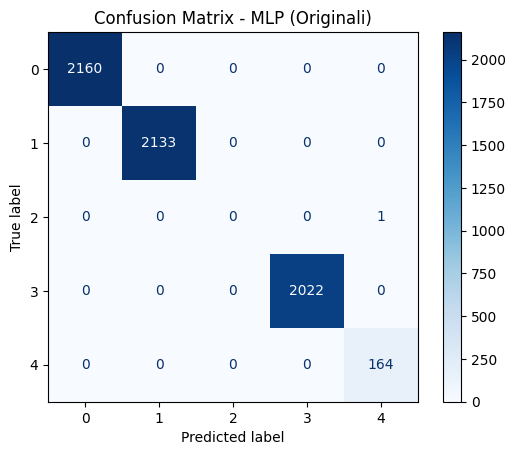

,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
0,0,100.00,0.00,0.0,0.00,0.0
1,0,100.00,0.00,0.0,0.00,0.0
2,1,0.00,100.00,0.0,0.00,0.0
3,3,0.00,0.00,0.0,100.00,0.0
4,1,0.00,99.83,0.0,0.16,0.0
...,...,...,...,...,...,...
6475,0,100.00,0.00,0.0,0.00,0.0
6476,0,100.00,0.00,0.0,0.00,0.0
6477,1,0.00,99.99,0.0,0.01,0.0
6478,0,100.00,0.00,0.0,0.00,0.0


In [20]:
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

[MLP_score, MLP_score_test] = evaluate_and_plot(mlp_model, X_train, y_train, X_test, y_test, name="MLP (Originali)")

,Training Set,Test Set
Accuracy,0.877932,0.851389
Precision,0.877382,0.850938
Recall,0.877932,0.851389
F1-score,0.877347,0.850817


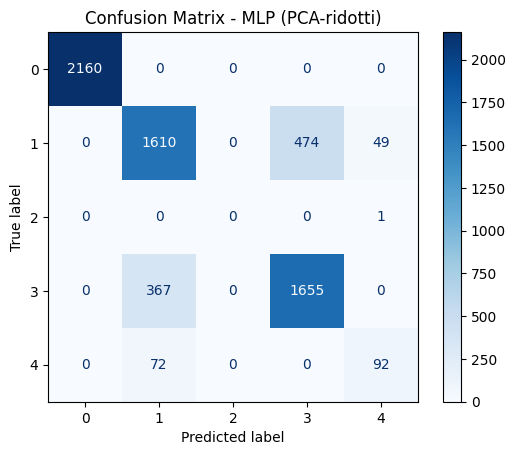

,Pred. Class,P(Class 0) - %,P(Class 1) - %,P(Class 2) - %,P(Class 3) - %,P(Class 4) - %
0,0,100.0,0.00,0.0,0.00,0.00
1,0,100.0,0.00,0.0,0.00,0.00
2,3,0.0,26.47,0.0,73.53,0.00
3,3,0.0,7.18,0.0,92.82,0.00
4,1,0.0,98.97,0.0,1.03,0.00
...,...,...,...,...,...,...
6475,0,100.0,0.00,0.0,0.00,0.00
6476,0,100.0,0.00,0.0,0.00,0.00
6477,1,0.0,66.48,0.0,29.82,3.69
6478,0,100.0,0.00,0.0,0.00,0.00


In [21]:
[MLP_score_PCA, MLP_score_test_PCA] = evaluate_and_plot(mlp_model, X_train_pca, y_train, X_test_pca, y_test, name="MLP (PCA-ridotti)")

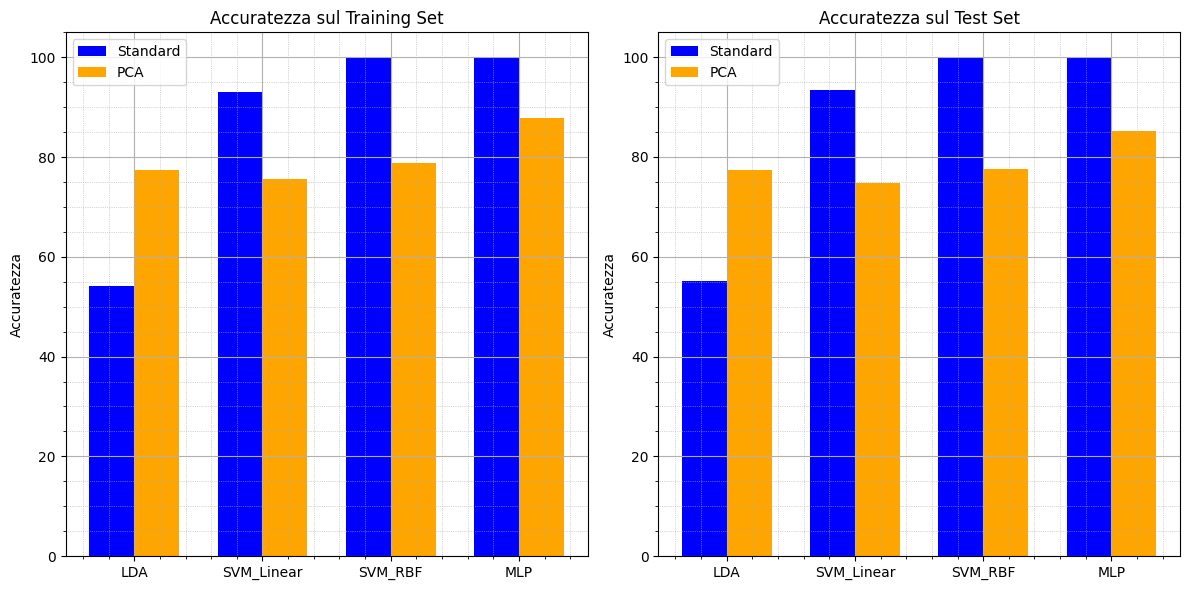

In [22]:
# Etichette raggruppate (senza PCA)
group_labels = ['LDA', 'SVM_Linear', 'SVM_RBF', 'MLP']

# Accuratezze in coppia (modello normale, poi PCA)
actrain = [LDA_score*100, LDA_score_PCA*100,
           SVMl_score*100, SVMl_score_PCA*100,
           SVMnl_score*100, SVMnl_score_PCA*100,
           MLP_score*100, MLP_score_PCA*100]

actest = [LDA_score_test*100, LDA_score_test_PCA*100,
          SVMl_score_test*100, SVMl_score_test_PCA*100,
          SVMnl_score_test*100, SVMnl_score_test_PCA*100,
          MLP_score_test*100, MLP_score_test_PCA*100]

# Colori alternati
colors = ['blue', 'orange'] * 4

x = np.arange(len(group_labels))
width = 0.35

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Training
axs[0].bar(x - width/2, actrain[::2], width, color='blue', label='Standard')
axs[0].bar(x + width/2, actrain[1::2], width, color='orange', label='PCA')
axs[0].set_xticks(x)
axs[0].set_xticklabels(group_labels)
axs[0].set_title('Accuratezza sul Training Set')
axs[0].set_ylabel('Accuratezza')
axs[0].grid(True)
axs[0].minorticks_on()
axs[0].grid(which='minor', linestyle=':', linewidth=0.5)
axs[0].legend()

# Test
axs[1].bar(x - width/2, actest[::2], width, color='blue', label='Standard')
axs[1].bar(x + width/2, actest[1::2], width, color='orange', label='PCA')
axs[1].set_xticks(x)
axs[1].set_xticklabels(group_labels)
axs[1].set_title('Accuratezza sul Test Set')
axs[1].set_ylabel('Accuratezza')
axs[1].grid(True)
axs[1].minorticks_on()
axs[1].grid(which='minor', linestyle=':', linewidth=0.5)
axs[1].legend()

plt.tight_layout()
plt.show()

<h1><strong>Conclusioni</strong></h1>

<p><h3>Comparazione dell'accuracy per percentuali diverse per il training set, PCA al 90%</h3></p>
  <table>
  <tr>
    <td><img src="Images/Tep30.png" alt="Immagine 1" style="width: 300px;"></td>
    <td><img src="Images/Tep50.png" alt="Immagine 2" style="width: 300px;"></td>
    <td><img src="Images/Tep70.png" alt="Immagine 3" style="width: 300px;"></td>
  </tr>
  <tr style="text-align: center; font-style: italic;">
    <td>Train 70%</td>
    <td>Train 50%</td>
    <td>Train 30%</td>
  </tr>
</table>
<li>Durante l’analisi sperimentale, è emerso un comportamento differente tra i dati originali e quelli ridotti tramite PCA rispetto alla variazione della dimensione del training set. In particolare:
    <ul>
      <li>Con i dati originali, l’accuracy dei modelli di classificazione rimane pressoché stabile al variare della percentuale di dati utilizzata per il training. Questo è dovuto al fatto che l’intero spazio informativo è preservato: anche con meno dati, i modelli riescono a cogliere la struttura del problema grazie alla ricchezza e alla completezza delle feature</li>
      <li>Con i dati PCA-ridotti, la dimensione del training set influisce sensibilmente sull’accuratezza dei modelli. Riducendo il numero di componenti, si perde parte dell’informazione originale, e il nuovo spazio proiettivo risulta più compatto e meno interpretabile. In questo contesto, un training set troppo ampio può portare ad overfitting, poiché i modelli tendono ad adattarsi eccessivamente ai pattern indotti dalla trasformazione. Al contrario, una percentuale di training più contenuta favorisce una migliore generalizzazione, migliorando le performance sul test set</li>
    </ul>
  </li>
<p>Questo comportamento evidenzia come la riduzione dimensionale mediante PCA non solo influenzi la struttura dei dati, ma anche la sensibilità degli algoritmi rispetto alla quantità di dati utilizzata in fase di apprendimento. Per questo motivo, è fondamentale bilanciare opportunamente la scelta del numero di componenti con la dimensione del training set, al fine di ottenere prestazioni ottimali.</p>
<p><h3>Comparazione dell'accuracy per percentuali diverse per la PCA, training set al 50%</h3></p>
  <table>
  <tr>
    <td><img src="Images/PCA8T50.png" alt="Immagine 1" style="width: 300px;"></td>
    <td><img src="Images/PCA9T50.png" alt="Immagine 2" style="width: 300px;"></td>
    <td><img src="Images/PCA10T50.png" alt="Immagine 3" style="width: 300px;"></td>
  </tr>
  <tr style="text-align: center; font-style: italic;">
    <td>PCA(14) - 80%</td>
    <td>PCA(17) - 90%</td>
    <td>PCA(19) - 100%</td>
  </tr>
</table>
<p><strong>Confronto dei classificatori rispetto all’uso della PCA</strong></p>
<p>Il <strong>Linear Discriminant Analysis</strong> ha beneficiato fortemente della PCA quando questa è stata applicata con percentuale parziale di varianza, ottenendo un netto miglioramento rispetto all’uso dei dati originali. Tuttavia, con PCA al 100%, che pur mantiene tutta la varianza spiegata ma riduce le dimensioni rispetto ai dati originali, le prestazioni sono drasticamente peggiorate. Questo perché la PCA, pur preservando la varianza globale, non garantisce che le componenti utili alla separazione tra le classi siano tra le prime selezionate</p>
<p><p>Lo <strong>SVM lineare</strong>, invece, si è mostrato robusto alla riduzione dimensionale: le sue prestazioni rimangono elevate anche con PCA(19). Questo comportamento è dovuto alla natura del modello, che cerca un iperpiano di separazione e non è fortemente influenzato dalla distribuzione della varianza, finché le classi restano separabili nello spazio trasformato</p>
</p>
<p>Anche <strong>SVM con kernel RBF</strong> si è comportato bene con la PCA, mantenendo prestazioni alte sia con 27 feature che con PCA al 95–100%. Tuttavia, mostra una leggera sensibilità maggiore rispetto alla versione lineare, poiché la trasformazione non lineare del kernel può essere più influenzata dalla perdita di componenti rilevanti nella fase di riduzione
</p>
<p>Infine, il <strong>MLP</strong> ha mostrato un comportamento simile a SVM RBF. La riduzione dimensionale tramite PCA ha portato a un miglioramento delle prestazioni rispetto ai dati originali, grazie alla semplificazione del problema e alla riduzione del rumore. Le prestazioni si sono mantenute elevate fino alla soglia del 100%, ma tendono a calare se si riducono troppo le componenti. Questo è coerente con la natura delle reti neurali, che richiedono una buona rappresentazione dei dati in input per apprendere correttamente</p>

<p><h3>Differenza fra PCA() e PCA(19)</h3></p>
  <table>
  <tr>
    <td><img src="Images/PCA()TE.png" alt="Immagine 1" style="width: 300px;"></td>
    <td><img src="Images/PCA10T50.png" alt="Immagine 2" style="width: 300px;"></td>
  </tr>
  <tr style="text-align: center; font-style: italic;">
    <td>PCA()</td>
    <td>PCA(19)</td>
  </tr>
</table>
<li>Nel nostro esperimento abbiamo applicato la PCA al dataset per ridurre la dimensionalità e migliorare l’efficienza dei modelli di classificazione. In particolare, abbiamo confrontato due configurazioni:
    <ul>
      <li>PCA(): tutte le 27 componenti principali vengono mantenute. In questo caso, non si ha alcuna riduzione della dimensionalità, ma i dati sono stati trasformati in una nuova base ortogonale</li>
      <li>PCA(19): si mantengono solo le prime 19 componenti principali, che spiegano comunque il 100% della varianza (a causa di ridondanza nei dati originari), ma si riduce la dimensionalità del problema da 27 a 19</li>
    </ul>
  </li>
<p>Nonostante PCA() mantenga lo stesso numero di feature del dataset originale, l’applicazione della PCA migliora drasticamente le performance di LDA. Questo è dovuto al fatto che PCA trasforma il dataset in uno spazio ortogonale, migliorando la condizione numerica per il calcolo della matrice di covarianza e riducendo la dipendenza tra le feature. Di conseguenza, LDA riesce a identificare separazioni tra classi in modo molto più efficace</p>

Dal confronto delle matrici di confusione, possiamo osservare che la LDA è il classificatore, tra quelli presi in esame, che meglio approssima i dati PCA ridotti rispetto ai dati originali: questo accade perchè la LDA si basa sull’inversione della matrice di covarianza che però, nel caso in cui ci siano tante feature, potrebbe non essere invertibile. Di conseguenza, applicare la PCA prima dell’LDA permette di rendere più stabile la matrice di covarianza e di poterla invertire. Inoltre, la PCA scarta le componenti con varianza molto bassa che possono rappresentare del rumore, rendendo più robusta la LDA. 

Al contrario, l’SVM lineare e l’SVM non lineare si comportano meglio sui dati originali. Analizziamoli singolarmente:
SVM lineare: La PCA trova le direzioni di massima varianza globale, non quelle che separano meglio le classi, di conseguenza alcune feature importanti per la separazione tramite SVM lineare, potrebbero essere scartate dalla PCA. Inoltre, la PCA effettua una rotazione sullo spazio delle features, ma l’SVM lineare è sensibile all’orientamento dei dati, perciò le distanze dei dati ridotti con la PCA potrebbero non rappresentare più il dataset e fornire una separazione errata. 
SVM non lineare: La PCA non conserva le strutture non lineari, che invece sono essenziali nella separazione tramite SVM non lineare. 

La MLP, invece, si comporta quasi nello stesso modo sia con i dati originali che con i dati ridotti tramite la PCA. Questo comportamento è legato alla flessibilità delle reti neurali. Anche se la PCA riduce il numero di features, la MLP è in grado di riorganizzare le informazioni in modo efficiente, senza discostarsi troppo dai dati originali. 
